#### 환경설정

##### 1. Wandb

In [1]:
import wandb

# wandb 로그인
wandb.login(key="2fb604788cd6eed5aafafcc8d13a6aaa7737ac71")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/HyeonSeok/.netrc
wandb: Currently logged in as: vanillahub12 (boaz_woony-boaz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

##### 2. 라이브러리 로드

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import os
import math
import random
import pickle
import wandb
from tqdm import tqdm
from datetime import datetime
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import torchvision
import torchvision.models as models
from torch import Tensor
from torchsummary import summary
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.manifold import TSNE

##### 3. 경로 설정

In [4]:
ROOT = "/home/HyeonSeok/BOAZ-Chungzins/data/raw"
CHECKPOINT_PATH = "/home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint"
PICKLE_PATH = "/home/HyeonSeok/BOAZ-Chungzins/save_path/pickle"
text = "/home/HyeonSeok/BOAZ-Chungzins/data/metadata/train_test_split.txt"

##### 4. Seed 설정

In [5]:
def seed_everything(seed: int = 42):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # ✅ 모든 GPU에 동일하게
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # 추가: DataLoader에 worker_init_fn 활용 (아래 예시 참고)


## 1. Data Load

#### 1.1 Data Load

In [6]:
# WAV 파일이 있는 디렉토리 경로
data_dir = ROOT
txt_dir = ROOT

df = pd.read_csv(text, sep='\t', header=None)

# 컬럼 이름 변경
df.columns = ['filename', 'set']

# train, test split
train_df = df[df['set'] == 'train']
test_df = df[df['set'] == 'test']

# filename list
train_list = sorted(train_df['filename'].tolist())
test_list = sorted(test_df['filename'].tolist())

print(f'Train :{len(train_list)}, Test: {len(test_list)}, Total: {len(train_list) + len(test_list)}')

Train :539, Test: 381, Total: 920


#### 1.2 Pretext-Finetune Split

In [7]:
# shuffle train data
df_shuffled = train_df.sample(frac=1, random_state=42)

# split ratio
train_size = int(len(df_shuffled))

# pretrain, finetune split
pretrain_df = df_shuffled[:train_size]
finetune_df = pretrain_df

# filename list (pretext_list -> pretrain list)
pretrain_list = sorted(pretrain_df['filename'].tolist())
finetune_list = sorted(finetune_df['filename'].tolist())

# patient id list
pretrain_patient_list = []
for filename in pretrain_list:
    number = int(filename.split('_')[0])
    pretrain_patient_list.append(number)

finetune_patient_list = []
for filename in finetune_list:
    number = int(filename.split('_')[0])
    finetune_patient_list.append(number)

pretrain_patient_counts = pd.Series(pretrain_patient_list).value_counts()
finetune_patient_counts = pd.Series(finetune_patient_list).value_counts()

print(f"[Pretrain] 환자 수: {len(pretrain_patient_counts.index)}, 샘플 수: {pretrain_patient_counts.sum()}")
print(f"[Finetune] 환자 수: {len(finetune_patient_counts.index)}, 샘플 수: {finetune_patient_counts.sum()}")

[Pretrain] 환자 수: 79, 샘플 수: 539
[Finetune] 환자 수: 79, 샘플 수: 539


## 2. Data Preprocessing

#### 2.1 Args

        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)

In [8]:
class Args:
    # Audio & Spectrogram
    target_sr = 16000    # 4KHz
    frame_size = 1024
    hop_length = 512    # frame_size 절반
    n_mels = 64
    target_sec = 8

    # Augmentation
    time_mask_param = 0.5
    freq_mask_param = 0.5

    # Train
    lr = 1e-3 # adamw - 0.03
    warm = True                     # warm-up 사용 여부
    warm_epochs = 10                # warm-up 적용할 초기 epoch 수
    warmup_from = lr * 0.1          # warm-up 시작 learning rate (보통 lr의 10%)
    warmup_to = lr

    batch_size = 128
    workers = 2
    epochs = 200
    weight_decay = 0.0

    resume = None
    schedule=[120, 160] # schedule

    # MLS
    K = 512
    momentum = 0.999
    T = 0.07
    dim_prj = 128
    top_k = 20
    lambda_bce = 0.3
    out_dim = 512

    # Linear Evaluation
    # ft_epochs = 3

    # etc
    gpu = 0
    data = "./data_path"
    seed=42
    num_classes = 2

    # update
    ma_update = False
    ma_beta = 0.5
    target_type = 'grad_flow'
    alpha = 1


args = Args()

#### 2.2 Utils (func)

In [9]:
import torch.nn.functional as F
import random

# cycle의 클래스를 추출
def get_class(cr, wh):
    if cr == 1 and wh == 1:
        return 3
    elif cr == 0 and wh == 1:
        return 2
    elif cr == 1 and wh == 0:
        return 1
    elif cr == 0 and wh == 0:
        return 0
    else:
        return -1

# Mel Spectrogram 생성 ( sr=4KHz, frame_size=1024, hop_length=512, n_mels=128 )
# def generate_mel_spectrogram(waveform, sample_rate, frame_size, hop_length, n_mels):
#     if hop_length is None:
#         hop_length = frame_size // 2
#     mel_spec_transform = T.MelSpectrogram(
#         sample_rate=sample_rate,
#         n_fft=frame_size,
#         hop_length=hop_length,
#         n_mels=n_mels,
#         f_min=50,       # 논문 기준 주파수 범위 하한
#         f_max=2000      # 논문 기준 주파수 범위 상한
#     )
#     mel_spectrogram = mel_spec_transform(waveform)
#     mel_db = T.AmplitudeToDB()(mel_spectrogram)
    
#     # dB 스케일에서 매우 낮은 값은 0으로 마스킹
#     mel_db[mel_db <= -100.0] = 0.0
    
#     return mel_db

# 256 맟춰주기
def generate_mel_spectrogram(waveform, sample_rate, frame_size, hop_length, n_mels):
    if hop_length is None:
        hop_length = frame_size // 2

    mel_spec_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=frame_size,
        hop_length=hop_length,
        n_mels=n_mels,
        f_min=50,
        f_max=2000
    )
    mel_spectrogram = mel_spec_transform(waveform)
    mel_db = T.AmplitudeToDB()(mel_spectrogram)

    # dB 스케일에서 매우 낮은 값은 0으로 마스킹
    mel_db[mel_db <= -100.0] = 0.0

    # 🔧 가운데 padding 적용
    target_frames = 256
    current_frames = mel_db.shape[-1]
    if current_frames < target_frames:
        pad_total = target_frames - current_frames
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        mel_db = F.pad(mel_db, (pad_left, pad_right))  # center padding
    elif current_frames > target_frames:
        # 가운데 자르기
        start = (current_frames - target_frames) // 2
        mel_db = mel_db[:, :, start:start + target_frames]

    return mel_db

# Cycle Repeat 또는 Crop
def repeat_or_truncate_segment(mel_segment, target_frames):
    current_frames = mel_segment.shape[-1]
    if current_frames >= target_frames:
        return mel_segment[:, :, :target_frames]
    else:
        repeat_ratio = math.ceil(target_frames / current_frames)
        mel_segment = mel_segment.repeat(1, 1, repeat_ratio)
        return mel_segment[:, :, :target_frames]

def preprocess_waveform_segment(waveform, unit_length):

    """unit_length 기준으로 waveform을 repeat + padding 또는 crop하여 길이 정규화"""
    waveform = waveform.squeeze(0)  # (1, L) → (L,) 로 바꿔도 무방
    length_adj = unit_length - len(waveform)

    if length_adj > 0:
        # waveform이 너무 짧은 경우 → repeat + zero-padding
        half_unit = unit_length // 2

        if length_adj < half_unit:
            # 길이 차이가 작으면 단순 padding
            half_adj = length_adj // 2
            waveform = F.pad(waveform, (half_adj, length_adj - half_adj))
        else:
            # 반복 후 부족한 부분 padding
            repeat_factor = unit_length // len(waveform)
            waveform = waveform.repeat(repeat_factor)[:unit_length]
            remaining = unit_length - len(waveform)
            half_pad = remaining // 2
            waveform = F.pad(waveform, (half_pad, remaining - half_pad))
    else:
        # waveform이 너무 길면 앞쪽 1/4 내에서 랜덤 crop
        length_adj = len(waveform) - unit_length
        start = random.randint(0, length_adj // 4)
        waveform = waveform[start:start + unit_length]

    return waveform.unsqueeze(0)  # 다시 (1, L)로

# # 논문 기반: Circular padding 방식 적용
# # - waveform이 짧은 경우: circular padding으로 8초 길이 맞춤
# # - waveform이 긴 경우: 앞쪽 25% 범위 내에서 랜덤 crop
# def preprocess_waveform_segment(waveform, unit_length):
#     """
#     논문 기반: Circular padding 적용
#     - waveform이 짧은 경우: circular padding으로 8초 길이 맞춤
#     - waveform이 긴 경우: 앞쪽 25% 범위 내에서 랜덤 crop
#     """
#     waveform = waveform.squeeze(0)  # (1, L) → (L,)
#     current_len = waveform.size(0)

#     if current_len < unit_length:
#         pad_len = unit_length - current_len
#         # ➤ shape을 (1, L)로 바꾸고 pad 적용 후 다시 (L,)로
#         waveform = waveform.unsqueeze(0)  # (L,) → (1, L)
#         waveform = F.pad(waveform, (0, pad_len), mode='circular')
#         waveform = waveform.squeeze(0)    # (1, L+pad) → (L+pad,)
#     elif current_len > unit_length:
#         max_start = max(0, current_len - unit_length)
#         start = random.randint(0, max_start // 4)
#         waveform = waveform[start:start + unit_length]

#     return waveform.unsqueeze(0)  # (L,) → (1, L)

# 데이터 Spec Augmentation ( 0~80% Random Masking )
def apply_spec_augment(mel_segment):

    M = mel_segment.shape[-1]
    F = mel_segment.shape[-2]

    # torchaudio의 마스킹은 0부터 mask_param까지 균등분포에서 랜덤하게 길이를 선택
    time_masking = T.TimeMasking(time_mask_param=int(M * 0.8))
    freq_masking = T.FrequencyMasking(freq_mask_param=int(F * 0.8) )

    aug1 = freq_masking(mel_segment.clone())
    aug2 = time_masking(mel_segment.clone())
    aug3 = freq_masking(time_masking(mel_segment.clone()))

    return aug1, aug2, aug3

# Waveform resample
def resample_waveform(waveform, orig_sr, target_sr=args.target_sr):
    if orig_sr != target_sr:
        resampler = torchaudio.transforms.Resample(
            orig_freq=orig_sr,
            new_freq=target_sr
        )
        return resampler(waveform), target_sr
    return waveform, orig_sr

# Normalize - Mean/Std
# def get_mean_and_std(dataset):
#     """ 전체 mel-spectrogram에서 mean과 std 계산 """
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

#     cnt = 0
#     fst_moment = torch.zeros(1)
#     snd_moment = torch.zeros(1)
#     for inputs, _, _ in tqdm(dataloader, desc="[Calculating Mean/Std]"):
#         b, c, h, w = inputs.shape  # inputs: [1, 1, n_mels, time]
#         nb_pixels = b * h * w

#         fst_moment += torch.sum(inputs, dim=[0, 2, 3])
#         snd_moment += torch.sum(inputs**2, dim=[0, 2, 3])
#         cnt += nb_pixels

#     mean = fst_moment / cnt
#     std = torch.sqrt(snd_moment / cnt - mean**2)
#     return mean.item(), std.item()

def get_mean_and_std(dataset, mask_threshold=-99.0):
    """ 마스킹(-100 등)을 제외하고 mean/std 계산 """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

    cnt = 0
    fst_moment = 0.0
    snd_moment = 0.0

    for inputs, _, _ in tqdm(dataloader, desc="[Calculating Mean/Std]"):
        # mask: 유효한 mel 값만 추출 (e.g. > -99.0)
        valid = inputs[inputs > mask_threshold]  # 1D tensor

        fst_moment += valid.sum().item()
        snd_moment += (valid ** 2).sum().item()
        cnt += valid.numel()

    mean = fst_moment / cnt
    std = np.sqrt(snd_moment / cnt - mean**2)
    return mean, std

In [10]:
# import torch
# import torch.nn.functional as F
# import torchaudio.transforms as T
# import numpy as np
# import random
# import math

# # -------------------- Augmentation functions (Torch 기반) --------------------

# def spec_augment(mel, time_mask_ratio, freq_mask_ratio): # default: 0.8
#     M = mel.shape[-1]  # 시간 축
#     F = mel.shape[-2]  # 주파수 축

#     time_masking = T.TimeMasking(time_mask_param=int(M * time_mask_ratio))
#     freq_masking = T.FrequencyMasking(freq_mask_param=int(F * freq_mask_ratio))

#     mel = freq_masking(mel.clone())
#     mel = time_masking(mel)
#     return mel

# # def random_crop(mel, crop_size):
# #     if mel.shape[-1] <= crop_size:
# #         return mel
# #     start = torch.randint(0, mel.shape[-1] - crop_size + 1, (1,)).item()
# #     return mel[:, :, start:start + crop_size]

# def add_noise(mel, noise_level=0.005):
#     noise = torch.randn_like(mel) * noise_level
#     return mel + noise

# def pitch_shift(mel, n_steps=2):
#     shift = random.randint(-n_steps, n_steps)
#     if shift == 0:
#         return mel
#     if shift > 0:
#         mel = torch.cat([mel[:, shift:, :], mel[:, :shift, :]], dim=1)
#     else:
#         shift = abs(shift)
#         mel = torch.cat([mel[:, -shift:, :], mel[:, :-shift, :]], dim=1)
#     return mel

# def time_stretch(mel, min_rate=0.8, max_rate=1.2):
#     rate = random.uniform(min_rate, max_rate)
#     if rate == 1.0:
#         return mel

#     orig_size = mel.shape[-1]
#     target_size = int(orig_size * rate)
#     mel_stretched = F.interpolate(
#         mel, size=(mel.shape[1], target_size),
#         mode='bilinear', align_corners=False
#     )

#     if target_size > orig_size:
#         return mel_stretched[:, :, :orig_size]
#     else:
#         padding = orig_size - target_size
#         return F.pad(mel_stretched, (0, padding))

# # -------------------- Dispatcher --------------------

# AUGMENTATION_FUNCTIONS_TORCH = {
#     "spec_augment": spec_augment,
#     # "random_crop": random_crop,
#     "add_noise": add_noise,
#     "pitch_shift": pitch_shift,
#     "time_stretch": time_stretch
# }

# def apply_augmentations_torch(x, methods=[], **kwargs):
#     for method in methods:
#         func = AUGMENTATION_FUNCTIONS_TORCH.get(method)
#         if func is None:
#             raise ValueError(f"Unknown augmentation: {method}")
#         x = func(x, **kwargs.get(method, {}))
#     return x


##############################################
import torch
import torch.nn.functional as F
import torchaudio.transforms as T
import numpy as np
import random

# -------------------- Augmentation functions (ICBHI 멜스펙트로그램에 최적화) --------------------

# def spec_augment(mel, time_mask_ratio=0.15, freq_mask_ratio=0.15):
#     """
#     SpecAugment: 시간/주파수 영역 마스킹
#     - 시간축 마스킹: 63 * 0.15 ≈ 9 프레임
#     - 주파수 마스킹: 128 * 0.1 ≈ 12 채널
#     """
#     M = mel.shape[-1]  # 시간 축
#     F = mel.shape[-2]  # 주파수 축

#     time_masking = T.TimeMasking(time_mask_param=max(1, int(M * time_mask_ratio)))
#     freq_masking = T.FrequencyMasking(freq_mask_param=max(1, int(F * freq_mask_ratio)))

#     mel = freq_masking(mel.clone())
#     mel = time_masking(mel)
#     return mel

# multi-label 논문용 spec
def spec_augment(mel, time_mask_param=20, freq_mask_param=40):
    """
    논문 기준:
    - 시간 마스킹: 최대 20 frame
    - 주파수 마스킹: 최대 40 mel bin
    """
    time_masking = T.TimeMasking(time_mask_param=time_mask_param)
    freq_masking = T.FrequencyMasking(freq_mask_param=freq_mask_param)

    mel = freq_masking(mel.clone())
    mel = time_masking(mel)
    return mel

def add_noise(mel, noise_level=0.001):
    """
    노이즈 추가: 적당한 수준의 표준 정규분포 노이즈 (너무 높으면 손실 커짐)
    """
    noise = torch.randn_like(mel) * noise_level
    return mel + noise

def pitch_shift(mel, n_steps=2):
    """
    주파수 축 순환 이동 (mel axis). shape은 그대로 유지됨.
    n_steps=2면 ±2 멜 채널만 이동.
    """
    shift = random.randint(-n_steps, n_steps)
    if shift == 0:
        return mel
    if shift > 0:
        mel = torch.cat([mel[:, :, shift:, :], mel[:, :, :shift, :]], dim=2)
    else:
        shift = abs(shift)
        mel = torch.cat([mel[:, :, -shift:, :], mel[:, :, :-shift, :]], dim=2)
    return mel

def time_stretch(mel, min_rate=0.95, max_rate=1.05):
    """
    시간 축 길이 조절. 너무 심하지 않게 ±5% 범위로만 조정.
    - shape 유지 위해 interpolation 후 crop/pad
    """
    rate = random.uniform(min_rate, max_rate)
    if rate == 1.0:
        return mel

    orig_size = mel.shape[-1]
    target_size = int(orig_size * rate)

    mel_stretched = F.interpolate(
        mel, size=(mel.shape[-2], target_size),  # (mel_bins, time)
        mode='bilinear',
        align_corners=False
    )

    if target_size > orig_size:
        return mel_stretched[..., :orig_size]
    else:
        pad = orig_size - target_size
        return F.pad(mel_stretched, (0, pad))

# -------------------- Dispatcher --------------------

AUGMENTATION_FUNCTIONS_TORCH = {
    "spec_augment": spec_augment,
    "add_noise": add_noise,
    "pitch_shift": pitch_shift,
    "time_stretch": time_stretch
}

def apply_augmentations_torch(x, methods=[], **kwargs):
    for method in methods:
        func = AUGMENTATION_FUNCTIONS_TORCH.get(method)
        if func is None:
            raise ValueError(f"Unknown augmentation: {method}")
        x = func(x, **kwargs.get(method, {}))
    return x


In [11]:
def aug(repeat_mel):
    # 먼저 복사본 준비
    mel1 = repeat_mel.clone()
    mel2 = repeat_mel.clone()

    # 각각 다른 증강 A, B 적용
    # aug1 = apply_augmentations_torch(mel1, methods=["add_noise"], add_noise={"noise_level": 0.005})
    # aug2 = apply_augmentations_torch(mel2, methods=["time_stretch"], time_stretch={"min_rate": 0.8, "max_rate": 1.2})
    # aug3 = apply_augmentations_torch(mel2, methods=["pitch_shift"], pitch_shift={"n_steps": 2})

    # # 각 결과에 spec_augment 추가 적용
    # aug1_spec = spec_augment(aug1)
    # aug2_spec = spec_augment(aug2, time_mask_ratio=0.6, freq_mask_ratio=0.4)
    # aug3_spec = spec_augment(aug3)

    ## 순수 spec_augment만 적용한 경우
    aug_speconly = spec_augment(mel1)

    return aug_speconly, None, None


def get_timestamp():
    """Outputs current time in KST like 2404070830"""
    kst_time = datetime.now(ZoneInfo("Asia/Seoul"))
    return kst_time.strftime('%y%m%d%H%M')

# Origin
# def aug(repeat_mel):
#     aug1, aug2, aug3 = apply_spec_augment(repeat_mel)
#     return aug1, aug2, aug3

#### 2.3 CycleDataset

In [12]:
import os
import torch
import torchaudio
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm import tqdm

class CycleDataset(Dataset):
    def __init__(self, filename_list, wav_dir, txt_dir, target_sec=args.target_sec, target_sr=args.target_sr, frame_size=args.frame_size, hop_length=args.hop_length, n_mels=args.n_mels, mean=None, std=None):
        self.filename_list = filename_list
        self.wav_dir = wav_dir
        self.txt_dir = txt_dir
        self.target_sec = target_sec
        self.target_sr = target_sr
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.mean = mean
        self.std = std

        self.cycle_list = []

        print("[INFO] Preprocessing cycles...")
        for filename in tqdm(self.filename_list):
            txt_path = os.path.join(self.txt_dir, filename + '.txt')
            wav_path = os.path.join(self.wav_dir, filename + '.wav')

            if not os.path.exists(txt_path):
                print(f"[WARNING] Missing file: {txt_path}")
            if not os.path.exists(wav_path):
                print(f"[WARNING] Missing file: {wav_path}")

            # Load annotation
            cycle_data = np.loadtxt(txt_path, usecols=(0, 1))
            lung_label = np.loadtxt(txt_path, usecols=(2, 3))

            # Load waveform
            waveform, orig_sr = torchaudio.load(wav_path)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)  # Stereo to mono
                print(' waveform.shape[0] > 1:')

            # Resample to target sample rate (4kHz)
            waveform, sample_rate = resample_waveform(waveform, orig_sr, self.target_sr)

            for idx in range(len(cycle_data)):
                # 호흡 주기 start, end
                start_sample = int(cycle_data[idx, 0] * sample_rate)
                end_sample = int(cycle_data[idx, 1] * sample_rate)
                lung_duration = cycle_data[idx, 1] - cycle_data[idx, 0]

                if end_sample <= start_sample:
                    print('end_sample <= start_sample:')
                    continue  # 잘못된 구간 스킵

                # Waveform repeat + padding 후 Mel_db
                cycle_wave = waveform[:, start_sample:end_sample]
                seg_wave = preprocess_waveform_segment(cycle_wave, unit_length=int(self.target_sec * self.target_sr))
                mel = generate_mel_spectrogram(seg_wave, sample_rate, frame_size=self.frame_size, hop_length=self.hop_length, n_mels=self.n_mels)

                # 정규화
                if self.mean is not None and self.std is not None:
                    mask_value = -100.0 # mel db 에서 마스킹된 값
                    mask = (mel == mask_value)
                    mel = (mel - mean) / std
                    mel[mask] = 0.0
                    
                # crackle, wheeze -> class
                cr = int(lung_label[idx, 0])
                wh = int(lung_label[idx, 1])
                label = get_class(cr, wh)

                multi_label = torch.tensor([
                    float(label in [1, 3]),
                    float(label in [2, 3])
                ])  # 변환된 multi-label 반환

                # meta_data
                meta_data = (filename, lung_duration)

                self.cycle_list.append((mel, multi_label, meta_data))

        print(f"[INFO] Total cycles collected: {len(self.cycle_list)}")

    def __len__(self):
        return len(self.cycle_list)

    def __getitem__(self, idx):
        mel, label, meta_data = self.cycle_list[idx]
        return mel, label, meta_data

##### Pickle.dump

CycleDataset 객체 생성

In [13]:
len(train_list)

539

In [14]:
# # # import random
# # # import matplotlib.pyplot as plt
# # # import librosa.display

# # # wav_dir = ROOT
# # # txt_dir = ROOT

# # # # 1. Dataset 로드
# # # train_dataset = CycleDataset(train_list, wav_dir, txt_dir)
# # # test_dataset = CycleDataset(test_list, wav_dir, txt_dir)

# # ################################################################

# import random
# import matplotlib.pyplot as plt
# import librosa.display

# wav_dir = ROOT
# txt_dir = ROOT

# # # mean, std 먼저 계산
# # normless_dataset = CycleDataset(train_list, wav_dir, txt_dir)
# # mean, std = get_mean_and_std(normless_dataset)

# # 정규화 적용된 데이터셋 생성
# train_dataset = CycleDataset(train_list, wav_dir, txt_dir)
# test_dataset = CycleDataset(test_list, wav_dir, txt_dir)

# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset
# }

# save_path = os.path.join(PICKLE_PATH, '0721_MLS_datasets.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(pickle_dict, f)



pickle로 train_dataset, test_dataset 외부 저장

In [15]:
# pickle_name = f'Aug_Moco_MLS_MelSpec_{args.target_sr//1000}kHz_{args.frame_size}win_{args.hop_length}hop_{args.n_mels}mel_{args.target_sec}s'

In [16]:
# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset
# }

# save_path = os.path.join(PICKLE_PATH, '3:7_saved_datasets_multilabel.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(pickle_dict, f)

# # #####

# # 🔹 mean, std 함께 저장
# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset,
#     'mean': mean,
#     'std': std
# }
# with open(os.path.join(PICKLE_PATH, 'pad0_norm_saved_datasets_multilabel.pkl'), 'wb') as f:
#     pickle.dump(pickle_dict, f)

# print(f'mean: {mean}, std: {std}')

In [17]:
# # 2. 간단 통계
# print(f"Total cycles: {len(train_dataset)}")

# label_counter = [0] * 4  # normal, crackle, wheeze, both
# for _, multi_label,_ in train_dataset:
#     if torch.equal(multi_label, torch.tensor([0., 0.])):
#         label_counter[0] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 0.])):
#         label_counter[1] += 1
#     elif torch.equal(multi_label, torch.tensor([0., 1.])):
#         label_counter[2] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 1.])):
#         label_counter[3] += 1

# for idx, count in enumerate(label_counter):
#     print(f"Class {idx}: {count} cycles")

##### Pickle.load
저장된 train_dataset, test_dataset을 로드  
(> Aug 는 Moco 모델에서 사용)

In [18]:
save_path = os.path.join(PICKLE_PATH, 'MLS_0722_16kHz_1024win_512hop_64mel_8s.pkl')
with open(save_path, 'rb') as f:
    pickle_dict = pickle.load(f)

train_dataset = pickle_dict['train_dataset']
test_dataset = pickle_dict['test_dataset']

print(f"[Train] Cycles: {len(train_dataset)}")
print(f"[Test] Cycles: {len(test_dataset)}")

###################

# save_path = os.path.join(PICKLE_PATH, 'pad0_norm_saved_datasets_multilabel.pkl')
# # 🔹 load with normalization values
# with open(save_path, 'rb') as f:
#     pickle_dict = pickle.load(f)

# train_dataset = pickle_dict['train_dataset']
# test_dataset = pickle_dict['test_dataset']
# mean = pickle_dict['mean']
# std = pickle_dict['std']

# print(f"[Train] Cycles: {len(train_dataset)}")
# print(f"[Test] Cycles: {len(test_dataset)}")
# print(f"[INFO] Loaded mean={mean:.4f}, std={std:.4f}")

[Train] Cycles: 4142
[Test] Cycles: 2756


In [19]:
train_dataset[0][0].shape

torch.Size([1, 64, 256])

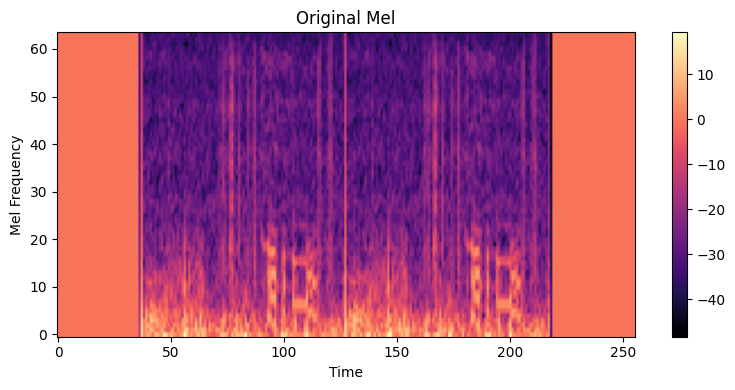

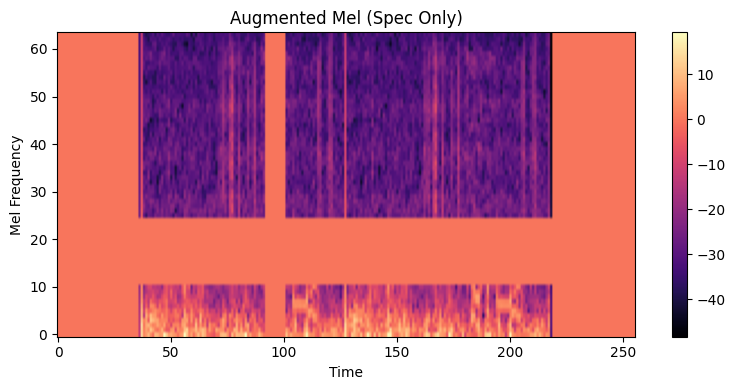

In [20]:
import matplotlib.pyplot as plt

# 데이터 로드
mel = train_dataset[0][0]  # (1, 64, 256)

# 증강 적용
aug_speconly, _ , _ = aug(mel)  # aug1: speconly, aug2: speconly

# 시각화 함수
def show_mel(mel_tensor, title):
    # 텐서 shape이 (1, 64, 256) 또는 (1, 1, 64, 256)일 수 있음
    if mel_tensor.ndim == 4:
        mel_tensor = mel_tensor.squeeze(0)  # (1, 64, 256)
    mel_np = mel_tensor.squeeze(0).cpu().numpy()  # (64, 256)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(mel_np, origin='lower', aspect='auto', cmap='magma')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()

# 시각화
show_mel(mel, "Original Mel")
show_mel(aug_speconly, "Augmented Mel (Spec Only)")


#### 2.4 DataLoader

In [21]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([0., 1.]),
 ('103_2b2_Ar_mc_LittC2SE', np.float64(2.886)))

In [22]:
train_dataset[9][0].shape

torch.Size([1, 64, 256])

In [23]:
# ---------------- 학습 데이터 구성(seed) ----------------
seed_everything(args.seed)

# train_dataset 내에서 각 파일의 인덱스를 추출
pretrain_idx = []
finetune_idx = []

for i in range(len(train_dataset)):
    filename = train_dataset[i][2][0]

    if filename in pretrain_list:
        pretrain_idx.append(i)
    # elif filename in finetune_list:
    #     finetune_idx.append(i)

    # pretrain = finetune
    if filename in finetune_list:
        finetune_idx.append(i)

# 인덱스 순서 셔플
random.shuffle(pretrain_idx)
random.shuffle(finetune_idx)

print(f"Pretrain set size: {len(pretrain_idx)}, Finetune set size: {len(finetune_idx)}")

Pretrain set size: 4142, Finetune set size: 4142


코드 실행 환경에 따라 num_workers를 적절한 값으로 지정해주세요!

In [24]:
# Dataset 생성 (Subset)
pretrain_dataset = Subset(train_dataset, pretrain_idx)
finetune_dataset = Subset(train_dataset, finetune_idx)

# DataLoader 생성
# DataLoader에서 shuffle=True로 지정하면 매 epoch마다 셔플 순서가 달라짐 => 재현성 문제 발생
# pretrain_dataset, finetune_dataset은 이미 셔플이 완료된 것으로, 이것을 DataLoader에 입력함
pretrain_loader = DataLoader(
    pretrain_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    shuffle=False
)

finetune_loader = DataLoader(
    finetune_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    pin_memory=True,
    shuffle=False
)

label 분포 확인 (단순 참고용, 실제 환경에서는 pretrain set의 label 분포가 어떤지 알 수 없음)

In [25]:
from collections import Counter

# label
labels = torch.stack([multi_label for _, multi_label, _ in train_dataset])

# pretext와 finetune 데이터셋의 라벨 분포 출력
pretrain_labels = labels[pretrain_idx]
pretrain_labels_class = (
    pretrain_labels[:, 0].long() * 1 +  # crackle bit → *1
    pretrain_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}
finetune_labels = labels[finetune_idx]
finetune_labels_class = (
    finetune_labels[:, 0].long() * 1 +  # crackle bit → *1
    finetune_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

# test 데이터셋의 라벨 분포 출력
test_labels = torch.stack([multi_label for _, multi_label, _ in test_dataset])
test_labels_class = (
    test_labels[:, 0].long() * 1 +  # crackle bit → *1
    test_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

print(f"Pretrain sample: {len(pretrain_labels_class)}")
print("Pretrain label distribution:", Counter(pretrain_labels_class.tolist()))
print(f"\nFinetune sample: {len(finetune_labels_class)}")
print("Finetune label distribution:", Counter(finetune_labels_class.tolist()))
print(f"Test sample: {len(test_labels_class)}")
print("Test label distribution:", Counter(test_labels_class.tolist()))

Pretrain sample: 4142
Pretrain label distribution: Counter({0: 2063, 1: 1215, 2: 501, 3: 363})

Finetune sample: 4142
Finetune label distribution: Counter({0: 2063, 1: 1215, 2: 501, 3: 363})
Test sample: 2756
Test label distribution: Counter({0: 1579, 1: 649, 2: 385, 3: 143})


## 3. Modeling

#### 3.1 Pre-trained ResNet50

In [26]:
# def backbone_resnet():
#     # 1. 기본 ResNet50 생성 (pretrained=False로 시작)
#     resnet = models.resnet50(pretrained=False)

#     # 2. 첫 번째 conv 레이어를 1채널용으로 수정
#     resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

#     # 먼저 fc 제거
#     resnet.fc = nn.Identity()

#     # 3. ImageNet 가중치 로드 (conv1 제외)
#     state_dict = load_state_dict_from_url(
#         'https://download.pytorch.org/models/resnet50-19c8e357.pth',
#         progress=True
#     )
#     if 'conv1.weight' in state_dict:
#         del state_dict['conv1.weight']
#     resnet.load_state_dict(state_dict, strict=False)

#     return resnet

In [27]:
from torchvision.models import resnet50, ResNet50_Weights

class ResNet50(torchvision.models.resnet.ResNet):
    def __init__(self, track_bn=True):
        def norm_layer(*args, **kwargs):
            return nn.BatchNorm2d(*args, **kwargs, track_running_stats=track_bn)
        super().__init__(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], norm_layer=norm_layer)
        del self.fc
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.final_feat_dim = 2048

    def load_sl_official_weights(self, progress=True):
        weights = ResNet50_Weights.DEFAULT
        state_dict = weights.get_state_dict(progress=progress)

        del state_dict['conv1.weight']
        missing, unexpected = self.load_state_dict(state_dict, strict=False)
        # if len(missing) > 0:
            # raise AssertionError('Model code may be incorrect')

    def load_ssl_official_weights(self, progress=True):
        # only SimCLR is available
        from pl_bolts.models.self_supervised import SimCLR
        
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
        simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)

        state_dict = {}
        for k, v in simclr.state_dict().items():
            if 'encoder.' in k:
                k = k.replace('encoder.', '')
            if 'fc' not in k or 'project' not in k:
                state_dict[k] = v
        missing, unexpected = self.load_state_dict(state_dict, strict=False)
        # non_linear_evaluator.block_forward is a pretrained MLP classifier for SimCLR
        # refer to https://github.com/Lightning-AI/lightning-bolts/blob/bcbbf6ab6c36430946dd8a416ddc7e697e8507fc/pl_bolts/models/self_supervised/evaluator.py#L7
        if len(missing) > 0:
            raise AssertionError('Model code may be incorrect')

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # x = self.fc(x)

        return x

In [28]:
def backbone_resnet50_patch():
    """
    MoCo 구조에 사용할 CNN6 백본 정의 함수.
    
    주요 변경 사항:
    - ResNet50 대신 CNN6 클래스 사용
    - 출력 feature dim은 512로 고정됨 (MoCo에서는 dim_enc=2048 → 이 부분만 맞춰서 사용하면 문제 없음)
    - ImageNet pretrained 사용 대신 공식 CNN6 pretrained 로딩 함수 포함 (옵션 사용 가능)
    """
    model = ResNet50()

    # 공식 SL pretrained weight를 사용하고자 할 경우 아래 줄을 주석 해제
    model.load_sl_official_weights()

    return model


#### 3.2 Pre-trained CNN6

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """
    nn.init.xavier_uniform_(layer.weight)
    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
            

def init_bn(bn):
    """Initialize a Batchnorm layer. """
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)


class ConvBlock5x5(nn.Module): #for CNN6
    def __init__(self, in_channels, out_channels, stride=(1,1)):
        
        super(ConvBlock5x5, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(5, 5), stride=stride,
                              padding=(2, 2), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.init_weight()
        
    def init_weight(self):
        init_layer(self.conv1)
        init_bn(self.bn1)
        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')
        
        return x


class CNN6(nn.Module):
    def __init__(self):
        super(CNN6, self).__init__()
        self.final_feat_dim = 512

        self.do_dropout = False
        self.conv_block1 = ConvBlock5x5(in_channels=1, out_channels=64, stride=(1,1))
        self.conv_block2 = ConvBlock5x5(in_channels=64, out_channels=128, stride=(1,1))
        self.conv_block3 = ConvBlock5x5(in_channels=128, out_channels=256, stride=(1,1))
        self.conv_block4 = ConvBlock5x5(in_channels=256, out_channels=512, stride=(1,1))
        self.dropout = nn.Dropout(0.2)
        # self.linear = nn.Linear(512, num_classes, bias=True)

    def load_sl_official_weights(self):
        """ download AudioSet pretrained CNN6 in https://zenodo.org/record/3960586#.Y8dz8y_kEiY
        """
        weights = torch.load('/home/HyeonSeok/Cnn6_mAP=0.343.pth')['model']
        state_dict = {k: v for k, v in weights.items() if k in self.state_dict().keys()}
        missing, unexpected = self.load_state_dict(state_dict, strict=False)

    def forward(self, x, return_feature_map=False):
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        
        if return_feature_map:
            return x  # shape: (B, 512, 4, 16)

        x = torch.mean(x, dim=3) #mean over time dim
        (x1, _) = torch.max(x, dim=2) #max over freq dim
        x2 = torch.mean(x, dim=2) #mean over freq dim (after mean over time)
        x = x1 + x2

        # if self.embed_only:
        #     return x
        # return self.linear(x)
        return x

In [30]:
def backbone_cnn6():
    """
    MoCo 구조에 사용할 CNN6 백본 정의 함수.
    
    주요 변경 사항:
    - ResNet50 대신 CNN6 클래스 사용
    - 출력 feature dim은 512로 고정됨 (MoCo에서는 dim_enc=2048 → 이 부분만 맞춰서 사용하면 문제 없음)
    - ImageNet pretrained 사용 대신 공식 CNN6 pretrained 로딩 함수 포함 (옵션 사용 가능)
    """
    model = CNN6()

    # 공식 SL pretrained weight를 사용하고자 할 경우 아래 줄을 주석 해제
    model.load_sl_official_weights()

    return model


##### 3.3 Multilabel Attention

In [31]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class MultilabelAttention(nn.Module):
#     def __init__(self, backbone, num_classes=2, lambda_attn=0.5, attention_heads=[1, float('inf')]):
#         super(MultilabelAttention, self).__init__()
#         self.backbone = backbone()
#         self.num_classes = num_classes
#         self.lambda_attn = lambda_attn
#         self.attention_heads = attention_heads  # e.g., [1, inf] for H=2

#         self.class_weights = nn.Parameter(torch.randn(len(attention_heads), num_classes, 512))

#         self.output_layer = nn.ModuleList([
#             nn.Linear(512, 1) for _ in range(num_classes)
#         ])

#     def forward(self, x):
#         # CNN6 백본 통과 → shape: (B, 512, 4, 16)
#         feat_map = self.backbone(x, return_feature_map=True)  # (B, 512, 4, 16)

#         B, C, Freq, Time = feat_map.shape
#         flat_feat = feat_map.view(B, C, Freq * Time).permute(0, 2, 1)  # (B, 64, 512)

#         # Class-specific attention a_i 계산
#         attn_outputs = []
#         for h, T in enumerate(self.attention_heads):
#             Ci = self.class_weights[h]  # (num_classes, 512)
#             logits = torch.einsum("bnc, kc -> bnk", flat_feat, Ci)  # (B, 64, num_classes)
#             logits = logits.permute(0, 2, 1)  # (B, num_classes, 64)
#             if T == float('inf'):
#                 attn_scores = F.one_hot(torch.argmax(logits, dim=2), num_classes=logits.shape[2]).float()
#             else:
#                 attn_scores = F.softmax(T * logits, dim=2)  # (B, num_classes, 64)

#             attn_scores = attn_scores.unsqueeze(-1)  # (B, num_classes, 64, 1)
#             flat_feat_exp = flat_feat.unsqueeze(1)  # (B, 1, 64, 512)
#             attn_feat = torch.sum(attn_scores * flat_feat_exp, dim=2)  # (B, num_classes, 512)
#             attn_outputs.append(attn_feat)

#         # Class-specific global feature g_i 계산
#         feat_avg_t = torch.mean(feat_map, dim=3)  # (B, 512, Freq)
#         gmp = torch.max(feat_avg_t, dim=2)[0]     # (B, 512)
#         gap = torch.mean(feat_avg_t, dim=2)       # (B, 512)
#         g = gmp + gap                             # (B, 512)
#         g = g.unsqueeze(1).repeat(1, self.num_classes, 1)  # (B, num_classes, 512)

#         # Combine: f_i = g_i + lambda * a_i
#         combined = g
#         for attn in attn_outputs:
#             combined = combined + self.lambda_attn * attn  # sum over heads

#         # Output layer for each class
#         out = []
#         for i in range(self.num_classes):
#             cls_feat = combined[:, i, :]  # (B, 512)
#             logit = self.output_layer[i](cls_feat).squeeze(-1)  # (B,)
#             out.append(logit)

#         logits = torch.stack(out, dim=1)  # (B, num_classes)
#         probs = torch.sigmoid(logits)    # (B, num_classes)
#         return combined, logits, probs                 # 마지막 dim: (B, 2, 512) 


# def backbone_mlattention():
#     """
#     Multi-label attention 기반 backbone 정의 함수
#     CNN6 기반 특징 추출기 + CSRA 기반 attention 구조 결합
    
#     Returns:
#         nn.Module: Multi-label attention 기반 분류기
#     """
#     return MultilabelAttention(backbone=backbone_cnn6, num_classes=2, lambda_attn=0.5, attention_heads=[1, float('inf')])


In [32]:
# x = torch.randn(10, 1, 64, 256) # B=10
# model = backbone_mlattention()
# out = model(x)  # (B, 2, 512)

# print(f"\ntorch.Size : {out.shape}")  # → torch.Size([B=10, 2, 512])

##### 3.4 Mix-MultiLabel Attention

In [33]:
import torch
import torch.nn.functional as F
import numpy as np

def group_mix(group_spec, labels, beta=1.0):
    """
    Group-wise PatchMix (spatial domain) for group_spec of shape [B, 64, 512]
    """
    B, N, D = group_spec.shape  # B: 배치 크기, N: 그룹 수 (ex. 64), D: 차원 수 (ex. 512)
                                # e.g., group_spec.shape == [B, 64, 512]

    device = group_spec.device  # e.g., 'cuda:0'

    # 🔹 lam: beta 분포에서 샘플링 (mix 비율)
    lam = np.random.beta(beta, beta)  # scalar float (e.g., 0.66)

    # 🔹 num_mask: 총 N 그룹 중에서 몇 개를 섞을지 결정
    num_mask = int(N * (1. - lam))  # scalar int (e.g., 64 * 0.34 = 21)

    # 🔹 mask: 섞을 group index (공통)
    mask = torch.randperm(N)[:num_mask].to(device)  # shape: [num_mask] (e.g., [21])

    # 🔹 index: 다른 sample과 섞기 위해 순서를 섞음
    index = torch.randperm(B).to(device)  # shape: [B] (e.g., [3, 0, 1, 2])

    # 🔹 mix: 같은 위치의 group들을 index 기준으로 섞기
    mixed_group_spec = group_spec.clone()                  # shape: [B, 64, 512]
    mixed_group_spec[:, mask, :] = group_spec[index][:, mask, :]  
    # group_spec[index]: shape [B, 64, 512]
    # group_spec[index][:, mask, :]: shape [B, num_mask, 512]
    # 최종적으로 mixed_group_spec[:, mask, :]: shape [B, num_mask, 512]

    # 🔹 lam_tensor: 각 sample에 대해 lam 값을 broadcasting 하기 위한 텐서
    lam_tensor = torch.full((B,), lam, device=device)  # shape: [B] (e.g., [0.66, 0.66, 0.66, 0.66])

    # 🔹 return: 섞은 group, 원래 라벨, 섞인 라벨, lam 값, 섞인 index
    return mixed_group_spec, labels, labels[index], lam_tensor, index
    # mixed_group_spec: shape [B, 64, 512]
    # labels: shape [B] 또는 [B, C] (멀티클래스인지 멀티라벨인지에 따라 다름)
    # labels[index]: shape [B] 또는 [B, C]
    # lam_tensor: shape [B]
    # index: shape [B]


In [34]:
class GroupMixConLoss(torch.nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, proj_orig, proj_mix, labels_a, labels_b, lam, index):
        """
        proj_orig: [B, D]   # 원본 representation (e.g., global pooled feature)
        proj_mix : [B, D]   # group-mix 적용된 representation
        labels_a:  [B, C] or [B]   # 원래 라벨
        labels_b:  [B, C] or [B]   # 섞인 라벨
        lam:       [B]             # 각 샘플마다 lam 값
        index:     [B]             # 섞인 대상 인덱스
        """
        B = proj_orig.size(0)           # 배치 크기
        device = proj_orig.device

        # 🔹 L2 정규화
        proj_orig = F.normalize(proj_orig, dim=1)   # [B, D]
        proj_mix  = F.normalize(proj_mix, dim=1)    # [B, D]
        # print(f"proj_orig.shape: {proj_orig.shape}, proj_mix.shape: {proj_mix.shape}")

        # 🔹 유사도 행렬: mix vs. original 간의 내적
        sim_matrix = torch.matmul(proj_mix, proj_orig.T) / self.temperature  
        # [B, D] x [D, B] -> [B, B]

        # 🔹 마스크 A: 원래 자기 자신이랑만 1인 마스크
        mask_a = torch.eye(B, device=device)  # [B, B]

        # 🔹 마스크 B: 각 mix가 섞인 대상과 1인 마스크
        mask_b = torch.zeros_like(mask_a)     # [B, B]
        mask_b[torch.arange(B), index] = 1    # 예: i-th row에서 index[i] column에 1

        # 🔹 soft positive mask = lam * identity + (1 - lam) * mix_target
        # lam: [B] -> [B, 1], broadcasting 됨
        mask = lam.view(-1, 1) * mask_a + (1 - lam).view(-1, 1) * mask_b  # [B, B]

        # 🔹 softmax log-prob 계산
        log_prob = sim_matrix - torch.logsumexp(sim_matrix, dim=1, keepdim=True)  
        # log_softmax(sim_matrix, dim=1)과 동일
        # sim_matrix: [B, B], log_prob: [B, B]

        # 🔹 positive log-prob만 평균냄
        # 각 row (i)에서 soft positive에 해당하는 위치에 대해서만 log_prob * mask
        mean_log_prob_pos = (mask * log_prob).sum(dim=1) / mask.sum(dim=1)  # [B]

        # 🔹 전체 평균 loss
        loss = -mean_log_prob_pos.mean()  # scalar

        return loss


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MixMLATT(nn.Module):
    def __init__(self, backbone, num_classes=2, lambda_attn=0.5, attention_heads=[1, float('inf')], projector_dim=128):
        super(MixMLATT, self).__init__()
        self.num_classes = num_classes
        self.lambda_attn = lambda_attn
        self.attention_heads = attention_heads

        # CNN6 백본 (e.g., CNN6 → [B, 512, 4, 16])
        self.backbone = backbone()

        # Class-specific Attention weights: 각 head마다 [num_classes, 512]
        self.class_weights = nn.Parameter(torch.randn(len(attention_heads), num_classes, 512))

    def forward(self, x, mix_feature=False, patch_mix=False, y=None, lam=None, index=None):
        """
        Args:
            x: input spectrogram [B, 1, F, T]
            return_mix_feature: whether to return raw mixed [B, 64, 512] for CE/classifier
            patch_mix: whether to perform group-wise patch mix
            y: labels (only used when patch_mix is True)
            lam: lambda for mixup
            index: mix index for patch selection
        Returns:
            attn_feat: [B, num_classes, 512]
            logits: [B, num_classes]
            probs: [B, num_classes]
            raw_feat: [B, 64, 512] (for CE/classifier)
        """
        B = x.size(0)
        origin_feat = None

        # 1. CNN6 Backbone → [B, 512, 4, 16]
        feat_map = self.backbone(x, return_feature_map=True)  # (B, 512, 4, 16)

        # 2. Reshape → [B, 64, 512]
        feat_flat = feat_map.view(B, 512, -1).permute(0, 2, 1)  # (B, 64, 512)

        # 3. Optional: Patch-wise Mixing
        if patch_mix and y is not None:
            # 1. group_mix 수행
            # mixed_group_spec, labels, labels[index], lam_tensor, index
            feat_flat, label_origin, label_mix, lam, index = group_mix(feat_flat, y)

            # 2. origin_feat 저장
            origin_feat = feat_flat.detach() if mix_feature else None

        # 4. CSRA Attention
        attn_outputs = []
        for h, T in enumerate(self.attention_heads):
            class_weight = self.class_weights[h]  # (num_classes, 512)
            logits = torch.einsum("bnc,kc->bnk", feat_flat, class_weight)  # (B, 64, num_classes)
            logits = logits.permute(0, 2, 1)  # (B, num_classes, 64)

            if T == float('inf'):
                attn_scores = F.one_hot(torch.argmax(logits, dim=2), num_classes=logits.shape[2]).float()
            else:
                attn_scores = F.softmax(T * logits, dim=2)

            attn_scores = attn_scores.unsqueeze(-1)           # (B, num_classes, 64, 1)
            feat_exp = feat_flat.unsqueeze(1)                 # (B, 1, 64, 512)
            attn_feat = torch.sum(attn_scores * feat_exp, dim=2)  # (B, num_classes, 512)
            attn_outputs.append(attn_feat)

        # 5. Global Feature Aggregation
        feat_avg_t = torch.mean(feat_map, dim=3)  # (B, 512, Freq)
        gmp = torch.max(feat_avg_t, dim=2)[0]     # (B, 512)
        gap = torch.mean(feat_avg_t, dim=2)       # (B, 512)
        g = gmp + gap                             # (B, 512)
        g = g.unsqueeze(1).repeat(1, self.num_classes, 1)  # (B, num_classes, 512)

        # 6. Combine Global + Attention Feature
        attn_feat = g
        for attn in attn_outputs:
            attn_feat = attn_feat + self.lambda_attn * attn  # (B, num_classes, 512)

        # 8. Return
        if not patch_mix:
            return attn_feat, origin_feat # [B, 2, 512], [B, 64, 512]
        else:
            return attn_feat, origin_feat, label_origin, label_mix, lam, index


In [36]:
def backbone_mixmlatt():
    """
    Multi-label attention 기반 backbone 정의 함수
    CNN6 기반 특징 추출기 + CSRA 기반 attention 구조 결합
    
    Returns:
        nn.Module: Multi-label attention 기반 분류기
    """
    return MixMLATT(backbone=backbone_cnn6, num_classes=2, lambda_attn=0.5, attention_heads=[1, float('inf')])


In [37]:
# summary 함수 사용: (채널, 높이, 너비) 크기를 지정
summary(backbone_mixmlatt().to(device), input_size=(1, 64, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 256]           1,600
       BatchNorm2d-2          [-1, 64, 64, 256]             128
      ConvBlock5x5-3          [-1, 64, 32, 128]               0
            Conv2d-4         [-1, 128, 32, 128]         204,800
       BatchNorm2d-5         [-1, 128, 32, 128]             256
      ConvBlock5x5-6          [-1, 128, 16, 64]               0
            Conv2d-7          [-1, 256, 16, 64]         819,200
       BatchNorm2d-8          [-1, 256, 16, 64]             512
      ConvBlock5x5-9           [-1, 256, 8, 32]               0
           Conv2d-10           [-1, 512, 8, 32]       3,276,800
      BatchNorm2d-11           [-1, 512, 8, 32]           1,024
     ConvBlock5x5-12           [-1, 512, 4, 16]               0
             CNN6-13           [-1, 512, 4, 16]               0
Total params: 4,304,320
Trainable param

## 4. Training

In [38]:
next(iter(pretrain_loader))[0].shape

torch.Size([128, 1, 64, 256])

In [39]:
def validate(model, classifier, projector_0, projector_1, val_loader, criterion, device, args):
    """
    Multi-label + GroupMix Contrastive 평가용 검증 함수
    - args.target_type 에 따라 grad_block, grad_flow, etc. 처리
    - 입력: inputs [B, 1, F, T], labels [B, 2]
    - 출력: 평균 loss, 전체 label, 전체 예측값
    """
    import numpy as np
    model.eval()
    classifier.eval()
    projector_0.eval()
    projector_1.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 1. Original forward (patch_mix=False)
            attn_feat, _ = model(inputs, mix_feature=True, patch_mix=False)  # [B, 2, 512]

            # 2. Classification logits
            out = []
            for i in range(attn_feat.shape[1]):
                cls_feat = attn_feat[:, i, :]               # [B, 512]
                logit = classifier[i](cls_feat).squeeze(-1) # [B]
                out.append(logit)
            logits = torch.stack(out, dim=1)  # [B, 2]

            # 3. classification loss
            loss_ce = criterion[0](logits, labels)

            # 4. Projector1 (target type 설정)
            if args.target_type == 'grad_block':
                proj1_0 = projector_0(attn_feat[:, 0, :].detach())
                proj1_1 = projector_1(attn_feat[:, 1, :].detach())
            elif args.target_type == 'grad_flow':
                proj1_0 = projector_0(attn_feat[:, 0, :])
                proj1_1 = projector_1(attn_feat[:, 1, :])
            elif args.target_type == 'project_block':
                proj1_0 = projector_0(attn_feat[:, 0, :]).detach()
                proj1_1 = projector_1(attn_feat[:, 1, :]).detach()
            elif args.target_type == 'project_flow':
                proj1_0 = projector_0(attn_feat[:, 0, :])
                proj1_1 = projector_1(attn_feat[:, 1, :])

            # 5. PatchMix 적용 (mix_feature=True)
            mix_attn_feat, origin_feat, label_origin, label_mix, lam, index = model(inputs, y=labels, patch_mix=True, mix_feature=True)

            # 6. mix는 무조건 projector 통과
            proj2_0 = projector_0(mix_attn_feat[:, 0, :])
            proj2_1 = projector_1(mix_attn_feat[:, 1, :])

            # 7. Contrastive loss
            loss_con0 = criterion[1](proj1_0, proj2_0, label_origin, label_mix, lam, index)
            loss_con1 = criterion[1](proj1_1, proj2_1, label_origin, label_mix, lam, index)

            # 8. Total loss
            loss = loss_ce + args.alpha * (loss_con0 + loss_con1)
            running_loss += loss.item()

            # 9. Prediction
            preds = (torch.sigmoid(logits) > 0.5).int()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()   # [N, 2]
    all_labels = torch.cat(all_labels, dim=0).numpy() # [N, 2]

    avg_loss = running_loss / len(val_loader)
    return avg_loss, all_labels, all_preds


In [40]:
import os
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from torch.cuda.amp import GradScaler
import torch.nn as nn
import time
import torch
from torch.cuda.amp import GradScaler

who_are_you = 'others'

# from utils.meters import AverageMeter
################################
train_losses = []
test_losses = []
train_icbhi_scores = []
test_icbhi_scores = []
test_labels_all = []
test_preds_all = []
epochs = []

# 모델 지정하기 전 seed 고정 필요
seed_everything(args.seed) # Seed 고정

pretrain_project_name = f'0723_{who_are_you}_basefalse_{args.alpha}alpha_MultilabelAtt_T_{args.batch_size}bs_{get_timestamp()}'

# -------------------------------------------wan
# wandb 초기화 (프로젝트명, 실험 이름 등 설정)
wandb.init(
    project="0721_SBW_ICBHI_MLATT_all", # 프로젝트 이름
    name=f"{pretrain_project_name}",  # 실험 이름
    config={
        "epochs": args.epochs,
        "batch_size": args.batch_size,
        "lr": args.lr,
        "momentum": args.momentum,
        "weight_decay": args.weight_decay,
        "alpha": args.alpha
    }
)
# -------------------------------------------wan

################################
# 1. Model / Classifier 
model = MixMLATT(backbone=backbone_cnn6, 
                 num_classes=2, 
                 lambda_attn=0.5, 
                 attention_heads=[1, float('inf')]
                 ).cuda()

classifier = nn.ModuleList([nn.Linear(args.out_dim, 1) for _ in range(2)]).cuda()

# 2. Projector 0/1
projector_0 = nn.Sequential(nn.Linear(args.out_dim, args.out_dim),nn.ReLU(),nn.Linear(args.out_dim, args.dim_prj)).cuda()
projector_1 = nn.Sequential(nn.Linear(args.out_dim, args.out_dim),nn.ReLU(),nn.Linear(args.out_dim, args.dim_prj)).cuda()

# 3. EMA 선언
ema_model = deepcopy(model)
ema_projector_0 = deepcopy(projector_0)
ema_projector_1 = deepcopy(projector_1)
ema_classifier = deepcopy(classifier)
for m in [ema_model, ema_projector_0, ema_projector_1, ema_classifier]:
    m.eval()
    for p in m.parameters():
        p.requires_grad_(False)

# 4. criterion
criterion = [
    nn.BCEWithLogitsLoss().cuda(),       # criterion[0]: classification
    GroupMixConLoss(temperature=0.07).cuda()  # criterion[1]: contrastive
]

# 5. optimizer  
optimizer = optim.Adam(
    list(model.parameters()) + list(classifier.parameters()) + 
    list(projector_0.parameters()) + list(projector_1.parameters()),
    lr=args.lr, weight_decay=args.weight_decay
)


# 6. EMA (Exponential Moving Average) 설정
@torch.no_grad()
def update_ema(student, ema, beta=0.999):
    for param, ema_param in zip(student.parameters(), ema.parameters()):
        ema_param.data = beta * ema_param.data + (1 - beta) * param.data


# 7. Train
# Best loss 초기화
best_loss = float('inf')
best_epoch = -1

for epoch in range(args.epochs):
    # ===============================
    # Training
    # ===============================
    model.train()
    projector_0.train()
    projector_1.train()
    classifier.train()

    total_train_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0

    all_preds = []
    all_labels = []
    all_outputs = []

    pbar = tqdm(pretrain_loader, desc='Mix_MLATT Trainig only')
    for idx, (repeat_mel, labels, _) in enumerate(pbar):
        # # (0) EMA 저장
        # if args.ma_update:
        #     with torch.no_grad():
        #         ma_ckpt = [
        #             deepcopy(model.state_dict()),
        #             deepcopy(projector_0.state_dict()),
        #             deepcopy(projector_1.state_dict()),
        #             deepcopy(classifier.state_dict())
        #         ]

        repeat_mel = repeat_mel.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)
        bsz = labels.size(0)


        # (1) Original 이미지 forward
        # attn_feat: [B, 2, 512], origin_feat: [B, 64, 512]
        attn_feat, _ = model(repeat_mel, mix_feature=True, patch_mix=False)
        out = []
        for i in range(args.num_classes):
            cls_feat = attn_feat[:, i, :]  # (B, 512)
            logit = classifier[i](cls_feat).squeeze(-1)  # (B,)
            out.append(logit)
        logits = torch.stack(out, dim=1) # [B, 2]

        # (2) classification loss
        loss_ce = criterion[0](logits, labels)

        # (3) projector1 생성 (class별)
        if args.target_type == 'grad_block':
            proj1_0 = projector_0(attn_feat[:, 0, :].detach())   # [B, 128]
            proj1_1 = projector_1(attn_feat[:, 1, :].detach())
        elif args.target_type == 'grad_flow':
            proj1_0 = attn_feat[:, 0, :]
            proj1_1 = attn_feat[:, 1, :]
        elif args.target_type == 'project_block':
            proj1_0 = deepcopy(projector_0(attn_feat[:, 0, :]).detach())
            proj1_1 = deepcopy(projector_1(attn_feat[:, 1, :]).detach())
        elif args.target_type == 'project_flow':
            proj1_0 = projector_0(attn_feat[:, 0, :])
            proj1_1 = projector_1(attn_feat[:, 1, :])

        # (4) PatchMix 수행 (mix된 이미지 반환)
        mix_attn_feat, origin_feat, label_origin, label_mix, lam, index = model(repeat_mel, y=labels, patch_mix=True, mix_feature=True)

        # (5) mix는 무조건 projector 통과
        proj2_0 = mix_attn_feat[:, 0, :]  # [B, 128]
        proj2_1 = mix_attn_feat[:, 1, :]

        # (6) GroupMixConLoss & Final loss 계산
        loss_con0 = criterion[1](proj1_0, proj2_0, label_origin, label_mix, lam, index)
        loss_con1 = criterion[1](proj1_1, proj2_1, label_origin, label_mix, lam, index)
        loss = loss_ce + args.alpha * (loss_con0 + loss_con1)
        

        # (8) Backpopagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # (9) EMA 업데이트
        if args.ma_update:
            update_ema(model, ema_model, beta=args.ma_beta)
            update_ema(projector_0, ema_projector_0, beta=args.ma_beta)
            update_ema(projector_1, ema_projector_1, beta=args.ma_beta)
            update_ema(classifier, ema_classifier, beta=args.ma_beta)

        # (10) Loss 기록
        total_train_loss += loss.item()
        
        # 예측값과 실제값 저장 ( Ablation(4-1) threshold ?? )
        predicted = (torch.sigmoid(logits) > 0.5).float()
        all_preds.append(predicted.detach().cpu())
        all_labels.append(labels.detach().cpu())
        all_outputs.append(logits.detach().cpu())


    # train loss
    train_loss = total_train_loss / len(pretrain_loader)

    # Concatenate
    all_preds = torch.cat(all_preds, dim=0).numpy()    # shape: [N, 2]
    all_labels = torch.cat(all_labels, dim=0).numpy()  # shape: [N, 2]
    all_output = torch.cat(all_outputs, dim=0).numpy()

    print(f"[Epoch {epoch} | Train Loss: {train_loss:.4f}, attn_feat: {attn_feat.shape}")


    # =====================================
    # 2-Edited. Multi-class 민감도/특이도 계산
    # =====================================
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import wandb
    from sklearn.metrics import confusion_matrix

    def multilabel_to_multiclass(y):
        # Crackle → 1, Wheeze → 2, Both → 3, None → 0
        y = np.array(y)
        return y[:, 0] + y[:, 1]*2

    def evaluate_multiclass_confusion(y_true, y_pred, class_names=["Normal", "Wheeze", "Crackle", "Both"]):
        y_true_cls = multilabel_to_multiclass(y_true)
        y_pred_cls = multilabel_to_multiclass(y_pred)

        cm = confusion_matrix(y_true_cls, y_pred_cls, labels=[0, 1, 2, 3])

        # N_n: 정상 → 정상
        N_n = cm[0, 0]
        N_total = cm[0].sum()

        # 이상 클래스 정답 수: W, C, B
        W_total = cm[1].sum()
        C_total = cm[2].sum()
        B_total = cm[3].sum()

        # 각각의 정답 → 정확한 예측만 고려
        W_w = cm[1, 1]
        C_c = cm[2, 2]
        B_b = cm[3, 3]

        SP = N_n / (N_total + 1e-6) #spec
        SE = (W_w + C_c + B_b) / (W_total + C_total + B_total + 1e-6) #sense

        AS = (SP + SE) / 2
        HS = 2 * SP * SE / (SP + SE + 1e-6)

        return cm, SE, SP, y_true_cls, y_pred_cls

    def log_multiclass_conf_matrix_wandb(cm, class_names, sens, spec, normalize, tag):
        # Normalize (비율) 옵션
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
            fmt = '.2f'
            title = "Confusion Matrix (Normalized %)"
        else:
            fmt = 'd'
            title = "Confusion Matrix (Raw Count)"

        fig, ax = plt.subplots(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, ax=ax)

        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(title)

        icbhi_score = (sens + spec) / 2
        # 우하단에 성능 출력
        ax.text(
            0.99, 0.15,
            f"Sensitivity: {sens*100:.2f}%\nSpecificity: {spec*100:.2f}%\nICBHI Score: {icbhi_score*100:.2f}%",
            ha='right', va='bottom',
            transform=plt.gca().transAxes,
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
        )

        plt.tight_layout()
        # wandb.log({tag: wandb.Image(fig)})
        # plt.close(fig)
        return fig

    # 1. 4-class Confusion Matrix 평가
    class_names = ["Normal", "Crackle", "Wheeze", "Both"]
    cm_4x4, train_sens, train_spec, y_true_cls, y_pred_cls = evaluate_multiclass_confusion(all_labels, all_preds, class_names)
    icbhi_score = (train_sens + train_spec)/2

    print("4-Class Confusion Matrix:\n", cm_4x4)
    print(f"Sensitivity: {train_sens:.4f}, Specificity: {train_spec:.4f}, ICBHI Score: {icbhi_score:.4f}")


    # ===============================
    # 3. Validation
    # ===============================
    # test_loss, test_labels, test_preds = validate(
    #     model, test_loader, criterion, device
    # )

    test_loss, test_labels, test_preds = validate(
        model=ema_model if args.ma_update else model,
        classifier=ema_classifier if args.ma_update else classifier,
        projector_0=ema_projector_0 if args.ma_update else projector_0,
        projector_1=ema_projector_1 if args.ma_update else projector_1,
        val_loader=test_loader,
        criterion=criterion,
        device=device,
        args=args
    )

    precision = precision_score(test_labels, test_preds, average='macro')
    recall = recall_score(test_labels, test_preds, average='macro')
    f1 = f1_score(test_labels, test_preds, average='macro')

    test_cm_4x4, test_sens, test_spec, test_y_true_cls, test_y_pred_cls = evaluate_multiclass_confusion(test_labels, test_preds)
    test_icbhi_score = (test_sens+test_spec)/2

    print("[Validation] Confusion Matrix:\n", test_cm_4x4)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"[VALIDATION] Sensitivity: {test_sens:.4f}, Specificity: {test_spec:.4f}, Avg ICBHI Score: {(test_sens+test_spec)/2:.4f}")
    print("##################################################")


    # ===============================
    # 4. Confusion Matrix
    # ===============================

    # 2. Finetune Count Confusion Matrix 시각화
    fig_finetune_raw = log_multiclass_conf_matrix_wandb(cm_4x4, class_names, train_sens, train_spec, normalize=False, tag="Training_conf_matrix_raw")
    fig_finetune_norm = log_multiclass_conf_matrix_wandb(cm_4x4, class_names, train_sens, train_spec, normalize=True, tag="Training_conf_matrix_norm")

    # 3. Test Confusion Matrix 시각화
    fig_test_raw = log_multiclass_conf_matrix_wandb(test_cm_4x4, class_names, test_sens, test_spec, normalize=False, tag="test_conf_matrix_raw")
    fig_test_norm = log_multiclass_conf_matrix_wandb(test_cm_4x4, class_names, test_sens, test_spec, normalize=True, tag="test_conf_matrix_norm")

    # 4. log dictionary 생성 -------------------------------------------wan
    wandb_log_dict = {
        "finetune_conf_matrix_raw": wandb.Image(fig_finetune_raw),
        "finetune_conf_matrix_norm": wandb.Image(fig_finetune_norm),
        "test_conf_matrix_raw": wandb.Image(fig_test_raw),
        "test_conf_matrix_norm": wandb.Image(fig_test_norm)
    }
    # -------------------------------------------wan

    # =====================================
    # 5. Checkpoint (Every 100 epochs)
    # =====================================
    if (epoch + 1) % 100 == 0:
        ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_{epoch:03d}.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'classifier': classifier.state_dict(),
            'projector_0': projector_0.state_dict(),
            'projector_1': projector_1.state_dict(),
        }, ckpt_path)
        print(f"💾 Saved checkpoint to {ckpt_path}")

        # =====================================
        # EMA 모델 저장 (조건: EMA 활성화일 때)
        if args.ma_update:
            ema_ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_ema_{epoch:03d}.pth.tar"
            torch.save({
                'epoch': epoch + 1,
                'state_dict': ema_model.state_dict(),
                'classifier': ema_classifier.state_dict(),
                'projector_0': ema_projector_0.state_dict(),
                'projector_1': ema_projector_1.state_dict()
            }, ema_ckpt_path)
            print(f"💾 Saved EMA checkpoint to {ema_ckpt_path}")
        # ================================

    # ===============================
    # 6. Save Best Checkpoint
    # ===============================
    if test_loss < best_loss:
        best_loss = test_loss
        best_epoch = epoch
        best_ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_best.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'model': model.state_dict(),
            'classifier': classifier.state_dict(),
            'projector_0': projector_0.state_dict(),
            'projector_1': projector_1.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': best_loss
        }, best_ckpt_path)
        print(f"=> Saved best checkpoint (epoch: {epoch}, loss: {best_loss:.4f})")

        # ================================
        # EMA 모델 저장
        if args.ma_update:
            best_ema_ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_best_ema.pth.tar"
            torch.save({
                'epoch': epoch + 1,
                'state_dict': ema_model.state_dict(),
                'classifier': ema_classifier.state_dict(),
                'projector_0': ema_projector_0.state_dict(),
                'projector_1': ema_projector_1.state_dict(),
                'loss': best_loss
            }, best_ema_ckpt_path)
            print(f"=> Saved best EMA checkpoint (epoch: {epoch}, loss: {best_loss:.4f})")
        # ================================


        # 🔹 Confusion Matrix Logging for Best
        cm_best, sens_best, spec_best,_, _ = evaluate_multiclass_confusion(test_labels, test_preds, class_names)
        fig_best_raw = log_multiclass_conf_matrix_wandb(cm_best, class_names, sens_best, spec_best, normalize=False, tag="best_test_conf_matrix_raw")

        fig_best_norm = log_multiclass_conf_matrix_wandb(cm_best, class_names, sens_best, spec_best, normalize=True, tag="best_test_conf_matrix_norm")

        # -------------------------------------------wan
        wandb_log_dict.update({
            "best_test_conf_matrix_raw": wandb.Image(fig_best_raw),
            "best_test_conf_matrix_norm": wandb.Image(fig_best_norm)
        })
        # -------------------------------------------wan


    if epoch == args.epochs - 1:
        # 🔸 Confusion Matrix Logging for Last Epoch
        cm_last, sens_last, spec_last, _, _  = evaluate_multiclass_confusion(test_labels, test_preds, class_names)
        fig_last_raw = log_multiclass_conf_matrix_wandb(cm_last, class_names, sens_last, spec_last, normalize=False, tag="last_test_conf_matrix_raw")

        fig_last_norm = log_multiclass_conf_matrix_wandb(cm_last, class_names, sens_last, spec_last, normalize=True, tag="last_test_conf_matrix_norm")

        # -------------------------------------------wan
        wandb_log_dict.update({
            "last_test_conf_matrix_raw": wandb.Image(fig_last_raw),
            "last_test_conf_matrix_norm": wandb.Image(fig_last_norm)
        })
        # -------------------------------------------wan

    # =====================================
    # 7. Logging with wandb confusion matrix
    # =====================================

    # -------------------------------------------wan
    # step 1. metrics
    wandb.log({
        # Train metrics
        "Training/epoch": epoch,
        "Training/train_loss": train_loss,
        "Training/test_loss": test_loss,
        "Training/train_sens": train_sens,
        "Training/train_spec": train_spec,
        "Training/icbhi_score": icbhi_score,

        # Test metrics
        "Test/loss": test_loss,
        "Test/sensitivity": test_sens,
        "Test/specificity": test_spec,
        "Test/icbhi_score": test_icbhi_score
    })

    # step 2. Confusion matrix
    wandb.log(wandb_log_dict)

    # -------------------------------------------wan


    plt.close(fig_finetune_raw)
    plt.close(fig_finetune_norm)
    plt.close(fig_test_raw)
    plt.close(fig_test_norm)
    if 'fig_best_raw' in locals(): plt.close(fig_best_raw)
    if 'fig_best_norm' in locals(): plt.close(fig_best_norm)
    if 'fig_last_raw' in locals(): plt.close(fig_last_raw)
    if 'fig_last_norm' in locals(): plt.close(fig_last_norm)

    # # ===============================
    # # 8. Scheduler Step
    # # ===============================
    # scheduler.step()

    # ===============================
    # 9. Save Metrics
    # ===============================
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_icbhi_scores.append(icbhi_score)
    test_icbhi_scores.append(test_icbhi_score)
    epochs.append(epoch)
    # ================================

    # ================================
    # test_labels_all, test_preds_all에 저장
    # ================================
    test_labels_all.append(test_labels)
    test_preds_all.append(test_preds)
    # ================================


# -------------------------------------------wan
wandb.finish()
# -------------------------------------------wan



Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.51it/s]


[Epoch 0 | Train Loss: 5.3459, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1929   35   69   11]
 [1142   11   44    2]
 [ 456   16   15    6]
 [ 341    6   11    2]]
Sensitivity: 0.0136, Specificity: 0.9437, ICBHI Score: 0.4787


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1579    0    0    0]
 [ 649    0    0    0]
 [ 385    0    0    0]
 [ 143    0    0    0]]
Test Loss: 6.6152
[VALIDATION] Sensitivity: 0.0000, Specificity: 1.0000, Avg ICBHI Score: 0.5000
##################################################
=> Saved best checkpoint (epoch: 0, loss: 6.6152)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 1 | Train Loss: 4.1261, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [1184   15    0    0]
 [ 493    0    0    0]
 [ 360    0    0    0]]
Sensitivity: 0.0073, Specificity: 0.9995, ICBHI Score: 0.5034


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1572    7    0    0]
 [ 634   15    0    0]
 [ 384    1    0    0]
 [ 143    0    0    0]]
Test Loss: 6.6305
[VALIDATION] Sensitivity: 0.0127, Specificity: 0.9956, Avg ICBHI Score: 0.5042
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 2 | Train Loss: 4.1673, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2030   14    0    0]
 [1163   36    0    0]
 [ 491    2    0    0]
 [ 359    1    0    0]]
Sensitivity: 0.0175, Specificity: 0.9932, ICBHI Score: 0.5053


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1543   36    0    0]
 [ 577   72    0    0]
 [ 377    8    0    0]
 [ 141    2    0    0]]
Test Loss: 7.3974
[VALIDATION] Sensitivity: 0.0612, Specificity: 0.9772, Avg ICBHI Score: 0.5192
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 3 | Train Loss: 4.8013, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1985   59    0    0]
 [1054  145    0    0]
 [ 487    6    0    0]
 [ 327   33    0    0]]
Sensitivity: 0.0707, Specificity: 0.9711, ICBHI Score: 0.5209


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1574    5    0    0]
 [ 626   23    0    0]
 [ 384    1    0    0]
 [ 143    0    0    0]]
Test Loss: 7.2689
[VALIDATION] Sensitivity: 0.0195, Specificity: 0.9968, Avg ICBHI Score: 0.5082
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 4 | Train Loss: 4.4408, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1967   77    0    0]
 [1018  181    0    0]
 [ 482   11    0    0]
 [ 325   35    0    0]]
Sensitivity: 0.0882, Specificity: 0.9623, ICBHI Score: 0.5253


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1492   87    0    0]
 [ 527  122    0    0]
 [ 358   27    0    0]
 [ 130   13    0    0]]
Test Loss: 6.7044
[VALIDATION] Sensitivity: 0.1037, Specificity: 0.9449, Avg ICBHI Score: 0.5243
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 5 | Train Loss: 3.9088, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1902  142    0    0]
 [ 869  330    0    0]
 [ 468   22    3    0]
 [ 286   74    0    0]]
Sensitivity: 0.1623, Specificity: 0.9305, ICBHI Score: 0.5464


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1402  177    0    0]
 [ 453  196    0    0]
 [ 326   59    0    0]
 [ 121   22    0    0]]
Test Loss: 6.8358
[VALIDATION] Sensitivity: 0.1665, Specificity: 0.8879, Avg ICBHI Score: 0.5272
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 6 | Train Loss: 4.5956, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1856  187    1    0]
 [ 820  379    0    0]
 [ 458   33    2    0]
 [ 257  101    2    0]]
Sensitivity: 0.1857, Specificity: 0.9080, ICBHI Score: 0.5468


/home/HyeonSeok/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[Validation] Confusion Matrix:
 [[1400  179    0    0]
 [ 418  231    0    0]
 [ 322   63    0    0]
 [ 123   20    0    0]]
Test Loss: 7.0836
[VALIDATION] Sensitivity: 0.1963, Specificity: 0.8866, Avg ICBHI Score: 0.5414
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 7 | Train Loss: 4.3797, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1846  198    0    0]
 [ 766  433    0    0]
 [ 448   38    6    1]
 [ 244  113    3    0]]
Sensitivity: 0.2139, Specificity: 0.9031, ICBHI Score: 0.5585
[Validation] Confusion Matrix:
 [[1381  193    5    0]
 [ 429  220    0    0]
 [ 320   61    3    1]
 [ 120   23    0    0]]
Test Loss: 7.0594
[VALIDATION] Sensitivity: 0.1895, Specificity: 0.8746, Avg ICBHI Score: 0.5320
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 8 | Train Loss: 4.0222, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1799  242    3    0]
 [ 643  555    1    0]
 [ 400   46   43    4]
 [ 207  130   16    7]]
Sensitivity: 0.2948, Specificity: 0.8801, ICBHI Score: 0.5875
[Validation] Confusion Matrix:
 [[1330  240    9    0]
 [ 377  271    1    0]
 [ 303   75    6    1]
 [ 114   29    0    0]]
Test Loss: 6.4748
[VALIDATION] Sensitivity: 0.2353, Specificity: 0.8423, Avg ICBHI Score: 0.5388
##################################################
=> Saved best checkpoint (epoch: 8, loss: 6.4748)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 9 | Train Loss: 4.4717, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1857  181    5    1]
 [ 708  491    0    0]
 [ 374   35   80    4]
 [ 207  108   33   12]]
Sensitivity: 0.2841, Specificity: 0.9085, ICBHI Score: 0.5963
[Validation] Confusion Matrix:
 [[1366  190   23    0]
 [ 433  212    4    0]
 [ 311   53   19    2]
 [ 122   20    1    0]]
Test Loss: 6.8539
[VALIDATION] Sensitivity: 0.1963, Specificity: 0.8651, Avg ICBHI Score: 0.5307
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 10 | Train Loss: 3.9425, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1804  232    7    1]
 [ 628  570    1    0]
 [ 352   32  105    4]
 [ 184  125   37   14]]
Sensitivity: 0.3358, Specificity: 0.8826, ICBHI Score: 0.6092
[Validation] Confusion Matrix:
 [[1235  308   36    0]
 [ 345  298    6    0]
 [ 268   88   25    4]
 [ 101   34    8    0]]
Test Loss: 6.3465
[VALIDATION] Sensitivity: 0.2744, Specificity: 0.7821, Avg ICBHI Score: 0.5283
##################################################
=> Saved best checkpoint (epoch: 10, loss: 6.3465)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 11 | Train Loss: 3.7710, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1801  226   16    1]
 [ 610  587    2    0]
 [ 304   31  150    8]
 [ 156  118   63   23]]
Sensitivity: 0.3704, Specificity: 0.8811, ICBHI Score: 0.6257
[Validation] Confusion Matrix:
 [[1279  202   97    1]
 [ 378  253   16    2]
 [ 278   46   51   10]
 [ 104   21   15    3]]
Test Loss: 6.5756
[VALIDATION] Sensitivity: 0.2608, Specificity: 0.8100, Avg ICBHI Score: 0.5354
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 12 | Train Loss: 3.7560, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1779  237   24    4]
 [ 554  639    3    3]
 [ 259   42  183    9]
 [ 130  114   76   40]]
Sensitivity: 0.4201, Specificity: 0.8704, ICBHI Score: 0.6452
[Validation] Confusion Matrix:
 [[1108  232  236    3]
 [ 355  261   25    8]
 [ 209   51  110   15]
 [  88   21   28    6]]
Test Loss: 5.9607
[VALIDATION] Sensitivity: 0.3203, Specificity: 0.7017, Avg ICBHI Score: 0.5110
##################################################
=> Saved best checkpoint (epoch: 12, loss: 5.9607)


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 13 | Train Loss: 3.5747, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1774  247   20    3]
 [ 511  682    3    3]
 [ 242   38  196   17]
 [ 119  121   72   48]]
Sensitivity: 0.4513, Specificity: 0.8679, ICBHI Score: 0.6596
[Validation] Confusion Matrix:
 [[1187  231  157    4]
 [ 366  263   17    3]
 [ 253   54   65   13]
 [  97   26   16    4]]
Test Loss: 6.3885
[VALIDATION] Sensitivity: 0.2821, Specificity: 0.7517, Avg ICBHI Score: 0.5169
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 14 | Train Loss: 3.7855, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1737  276   28    3]
 [ 448  744    1    6]
 [ 226   36  210   21]
 [  90  128   81   61]]
Sensitivity: 0.4946, Specificity: 0.8498, ICBHI Score: 0.6722
[Validation] Confusion Matrix:
 [[1178  250  149    2]
 [ 340  287   21    1]
 [ 231   67   76   11]
 [  83   35   19    6]]
Test Loss: 6.6683
[VALIDATION] Sensitivity: 0.3135, Specificity: 0.7460, Avg ICBHI Score: 0.5298
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 15 | Train Loss: 3.7183, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1770  251   22    1]
 [ 458  736    0    5]
 [ 230   32  210   21]
 [  92  114   95   59]]
Sensitivity: 0.4898, Specificity: 0.8659, ICBHI Score: 0.6779
[Validation] Confusion Matrix:
 [[1194  219  162    4]
 [ 394  229   25    1]
 [ 250   49   72   14]
 [  94   23   25    1]]
Test Loss: 6.4345
[VALIDATION] Sensitivity: 0.2566, Specificity: 0.7562, Avg ICBHI Score: 0.5064
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 16 | Train Loss: 4.2761, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1770  252   21    1]
 [ 480  712    1    6]
 [ 195   33  247   18]
 [  85  105  102   68]]
Sensitivity: 0.5005, Specificity: 0.8659, ICBHI Score: 0.6832
[Validation] Confusion Matrix:
 [[1058  264  248    9]
 [ 323  284   31   11]
 [ 205   57  100   23]
 [  65   36   30   12]]
Test Loss: 6.2795
[VALIDATION] Sensitivity: 0.3364, Specificity: 0.6700, Avg ICBHI Score: 0.5032
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 17 | Train Loss: 4.0859, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1804  213   24    3]
 [ 448  746    3    2]
 [ 207   16  242   28]
 [  80   96   92   92]]
Sensitivity: 0.5263, Specificity: 0.8826, ICBHI Score: 0.7044
[Validation] Confusion Matrix:
 [[1207  241  128    3]
 [ 356  273   17    3]
 [ 244   61   66   14]
 [  81   31   26    5]]
Test Loss: 6.4146
[VALIDATION] Sensitivity: 0.2923, Specificity: 0.7644, Avg ICBHI Score: 0.5283
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 18 | Train Loss: 3.8310, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1813  208   23    0]
 [ 435  756    5    3]
 [ 183   22  265   23]
 [  73  102  100   85]]
Sensitivity: 0.5390, Specificity: 0.8870, ICBHI Score: 0.7130
[Validation] Confusion Matrix:
 [[1275  164  138    2]
 [ 418  217   14    0]
 [ 269   40   67    9]
 [  97   22   21    3]]
Test Loss: 6.3277
[VALIDATION] Sensitivity: 0.2438, Specificity: 0.8075, Avg ICBHI Score: 0.5257
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 19 | Train Loss: 3.7726, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1787  228   28    1]
 [ 382  808    6    3]
 [ 159   21  280   33]
 [  67  102   84  107]]
Sensitivity: 0.5824, Specificity: 0.8743, ICBHI Score: 0.7283
[Validation] Confusion Matrix:
 [[1122  222  231    4]
 [ 349  272   23    5]
 [ 212   52  100   21]
 [  75   32   27    9]]
Test Loss: 6.5736
[VALIDATION] Sensitivity: 0.3237, Specificity: 0.7106, Avg ICBHI Score: 0.5171
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 20 | Train Loss: 4.4668, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1828  193   23    0]
 [ 412  783    2    2]
 [ 158   19  290   26]
 [  61   89   98  112]]
Sensitivity: 0.5775, Specificity: 0.8943, ICBHI Score: 0.7359
[Validation] Confusion Matrix:
 [[1104  232  232   11]
 [ 323  297   22    7]
 [ 191   59  106   29]
 [  67   33   27   16]]
Test Loss: 6.5408
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.6992, Avg ICBHI Score: 0.5276
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 21 | Train Loss: 3.9453, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1807  216   20    1]
 [ 354  838    1    6]
 [ 154   15  292   32]
 [  52   97   86  125]]
Sensitivity: 0.6116, Specificity: 0.8841, ICBHI Score: 0.7478
[Validation] Confusion Matrix:
 [[1011  284  275    9]
 [ 294  319   28    8]
 [ 184   62  114   25]
 [  59   33   39   12]]
Test Loss: 6.5028
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6403, Avg ICBHI Score: 0.5092
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 22 | Train Loss: 3.9910, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1816  202   26    0]
 [ 355  835    3    6]
 [ 151   17  294   31]
 [  54  103   80  123]]
Sensitivity: 0.6101, Specificity: 0.8885, ICBHI Score: 0.7493
[Validation] Confusion Matrix:
 [[986 298 282  13]
 [288 321  33   7]
 [170  67 116  32]
 [ 55  35  37  16]]
Test Loss: 6.6703
[VALIDATION] Sensitivity: 0.3849, Specificity: 0.6244, Avg ICBHI Score: 0.5047
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 23 | Train Loss: 4.0334, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1819  203   21    1]
 [ 333  860    1    5]
 [ 120   16  320   37]
 [  44   94   85  137]]
Sensitivity: 0.6418, Specificity: 0.8899, ICBHI Score: 0.7659
[Validation] Confusion Matrix:
 [[1158  195  217    9]
 [ 361  261   25    2]
 [ 219   46   97   23]
 [  72   27   35    9]]
Test Loss: 6.3173
[VALIDATION] Sensitivity: 0.3118, Specificity: 0.7334, Avg ICBHI Score: 0.5226
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 24 | Train Loss: 3.8611, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1838  187   18    1]
 [ 352  844    0    3]
 [ 119   18  327   29]
 [  41   92   77  150]]
Sensitivity: 0.6438, Specificity: 0.8992, ICBHI Score: 0.7715
[Validation] Confusion Matrix:
 [[1028  249  284   18]
 [ 313  293   36    7]
 [ 188   52  116   29]
 [  52   27   43   21]]
Test Loss: 6.8465
[VALIDATION] Sensitivity: 0.3653, Specificity: 0.6510, Avg ICBHI Score: 0.5082
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 25 | Train Loss: 3.8796, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1837  190   16    1]
 [ 327  866    3    3]
 [ 113   20  323   37]
 [  24  105   73  158]]
Sensitivity: 0.6564, Specificity: 0.8987, ICBHI Score: 0.7776
[Validation] Confusion Matrix:
 [[960 234 372  13]
 [311 286  40  12]
 [148  54 158  25]
 [ 49  25  49  20]]
Test Loss: 6.1788
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.6080, Avg ICBHI Score: 0.5011
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 26 | Train Loss: 3.9450, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1842  176   26    0]
 [ 300  892    2    5]
 [ 106   15  334   38]
 [  34   93   81  152]]
Sensitivity: 0.6715, Specificity: 0.9012, ICBHI Score: 0.7864
[Validation] Confusion Matrix:
 [[982 332 253  12]
 [300 318  24   7]
 [183  70 107  25]
 [ 63  39  26  15]]
Test Loss: 6.5473
[VALIDATION] Sensitivity: 0.3738, Specificity: 0.6219, Avg ICBHI Score: 0.4979
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 27 | Train Loss: 3.9123, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1854  173   15    2]
 [ 285  906    1    7]
 [ 114   15  332   32]
 [  28   97   77  158]]
Sensitivity: 0.6803, Specificity: 0.9070, ICBHI Score: 0.7937
[Validation] Confusion Matrix:
 [[1113  209  244   13]
 [ 359  254   32    4]
 [ 181   52  126   26]
 [  61   33   36   13]]
Test Loss: 6.1737
[VALIDATION] Sensitivity: 0.3339, Specificity: 0.7049, Avg ICBHI Score: 0.5194
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 28 | Train Loss: 4.1081, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1861  168   13    2]
 [ 285  910    1    3]
 [  99   13  356   25]
 [  22   91   73  174]]
Sensitivity: 0.7018, Specificity: 0.9105, ICBHI Score: 0.8061
[Validation] Confusion Matrix:
 [[1023  269  273   14]
 [ 317  297   24   11]
 [ 190   53  117   25]
 [  57   29   39   18]]
Test Loss: 6.7030
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.6479, Avg ICBHI Score: 0.5075
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 29 | Train Loss: 3.8453, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1876  155   12    1]
 [ 306  887    2    4]
 [  93   12  356   32]
 [  28   82   65  185]]
Sensitivity: 0.6959, Specificity: 0.9178, ICBHI Score: 0.8069
[Validation] Confusion Matrix:
 [[1151  158  263    7]
 [ 361  258   26    4]
 [ 204   49  117   15]
 [  72   25   35   11]]
Test Loss: 6.4125
[VALIDATION] Sensitivity: 0.3280, Specificity: 0.7289, Avg ICBHI Score: 0.5284
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 30 | Train Loss: 3.4521, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1877  159    8    0]
 [ 271  922    2    4]
 [ 100   17  339   37]
 [  26   89   60  185]]
Sensitivity: 0.7047, Specificity: 0.9183, ICBHI Score: 0.8115
[Validation] Confusion Matrix:
 [[1072  278  219   10]
 [ 306  311   28    4]
 [ 196   66  104   19]
 [  60   33   38   12]]
Test Loss: 6.3060
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6789, Avg ICBHI Score: 0.5208
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 31 | Train Loss: 3.6187, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1901  126   15    2]
 [ 275  916    2    6]
 [  75    9  382   27]
 [  16   72   59  213]]
Sensitivity: 0.7364, Specificity: 0.9300, ICBHI Score: 0.8332
[Validation] Confusion Matrix:
 [[1031  232  303   13]
 [ 319  291   28   11]
 [ 172   55  136   22]
 [  64   28   38   13]]
Test Loss: 6.6035
[VALIDATION] Sensitivity: 0.3738, Specificity: 0.6529, Avg ICBHI Score: 0.5134
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 32 | Train Loss: 3.5638, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1917  117   10    0]
 [ 251  939    3    6]
 [  72   12  382   27]
 [  14   66   58  222]]
Sensitivity: 0.7519, Specificity: 0.9379, ICBHI Score: 0.8449
[Validation] Confusion Matrix:
 [[1127  253  189   10]
 [ 306  315   19    9]
 [ 221   59   81   24]
 [  75   26   22   20]]
Test Loss: 6.3029
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7137, Avg ICBHI Score: 0.5336
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 33 | Train Loss: 3.6711, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1899  135   10    0]
 [ 203  992    0    4]
 [  77    7  379   30]
 [   9   67   50  234]]
Sensitivity: 0.7822, Specificity: 0.9291, ICBHI Score: 0.8556
[Validation] Confusion Matrix:
 [[1050  208  312    9]
 [ 320  285   35    9]
 [ 164   57  141   23]
 [  63   21   40   19]]
Test Loss: 6.1790
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6650, Avg ICBHI Score: 0.5215
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 34 | Train Loss: 3.9197, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1915  116   13    0]
 [ 218  977    2    2]
 [  75    9  386   23]
 [  17   67   43  233]]
Sensitivity: 0.7778, Specificity: 0.9369, ICBHI Score: 0.8573
[Validation] Confusion Matrix:
 [[1141  219  205   14]
 [ 322  302   18    7]
 [ 217   58   85   25]
 [  68   30   29   16]]
Test Loss: 6.7079
[VALIDATION] Sensitivity: 0.3424, Specificity: 0.7226, Avg ICBHI Score: 0.5325
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 35 | Train Loss: 3.3816, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1940   95    9    0]
 [ 189  999    2    9]
 [  69    4  389   31]
 [   6   57   39  258]]
Sensitivity: 0.8021, Specificity: 0.9491, ICBHI Score: 0.8756
[Validation] Confusion Matrix:
 [[1084  224  256   15]
 [ 310  304   28    7]
 [ 173   63  129   20]
 [  61   31   34   17]]
Test Loss: 6.6279
[VALIDATION] Sensitivity: 0.3823, Specificity: 0.6865, Avg ICBHI Score: 0.5344
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 36 | Train Loss: 3.1981, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1937   95   12    0]
 [ 181 1013    2    3]
 [  65    6  391   31]
 [   3   63   38  256]]
Sensitivity: 0.8090, Specificity: 0.9477, ICBHI Score: 0.8783
[Validation] Confusion Matrix:
 [[980 304 276  19]
 [282 329  28  10]
 [159  76 122  28]
 [ 60  35  31  17]]
Test Loss: 6.4289
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6206, Avg ICBHI Score: 0.5091
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 37 | Train Loss: 3.7688, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1946   88   10    0]
 [ 174 1020    2    3]
 [  49    7  416   21]
 [   3   47   44  266]]
Sensitivity: 0.8294, Specificity: 0.9521, ICBHI Score: 0.8907
[Validation] Confusion Matrix:
 [[985 267 315  12]
 [270 333  34  12]
 [143  71 140  31]
 [ 52  26  42  23]]
Test Loss: 6.5999
[VALIDATION] Sensitivity: 0.4214, Specificity: 0.6238, Avg ICBHI Score: 0.5226
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 38 | Train Loss: 3.6866, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1968   69    7    0]
 [ 165 1032    0    2]
 [  40    5  429   19]
 [   5   50   30  275]]
Sensitivity: 0.8460, Specificity: 0.9628, ICBHI Score: 0.9044
[Validation] Confusion Matrix:
 [[1119  191  259   10]
 [ 340  266   33   10]
 [ 173   64  121   27]
 [  61   21   40   21]]
Test Loss: 6.0752
[VALIDATION] Sensitivity: 0.3466, Specificity: 0.7087, Avg ICBHI Score: 0.5277
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 39 | Train Loss: 3.5929, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1983   54    7    0]
 [ 139 1058    0    2]
 [  53    3  413   24]
 [   3   54   28  275]]
Sensitivity: 0.8509, Specificity: 0.9702, ICBHI Score: 0.9105
[Validation] Confusion Matrix:
 [[1166  208  198    7]
 [ 317  304   22    6]
 [ 205   61   96   23]
 [  70   32   27   14]]
Test Loss: 6.3821
[VALIDATION] Sensitivity: 0.3517, Specificity: 0.7384, Avg ICBHI Score: 0.5451
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 40 | Train Loss: 3.7922, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1973   67    4    0]
 [ 134 1064    0    1]
 [  45    6  427   15]
 [   3   49   28  280]]
Sensitivity: 0.8631, Specificity: 0.9653, ICBHI Score: 0.9142
[Validation] Confusion Matrix:
 [[1027  282  246   24]
 [ 280  332   27   10]
 [ 166   72  116   31]
 [  48   40   34   21]]
Test Loss: 6.6828
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6504, Avg ICBHI Score: 0.5244
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 41 | Train Loss: 3.6402, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1970   65    9    0]
 [ 134 1062    1    2]
 [  57    4  414   18]
 [   1   44   28  287]]
Sensitivity: 0.8592, Specificity: 0.9638, ICBHI Score: 0.9115
[Validation] Confusion Matrix:
 [[1037  194  330   18]
 [ 318  282   41    8]
 [ 151   63  146   25]
 [  57   22   43   21]]
Test Loss: 6.3335
[VALIDATION] Sensitivity: 0.3815, Specificity: 0.6567, Avg ICBHI Score: 0.5191
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 42 | Train Loss: 3.8150, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1979   61    4    0]
 [ 138 1058    0    3]
 [  56    5  417   15]
 [   3   45   26  286]]
Sensitivity: 0.8582, Specificity: 0.9682, ICBHI Score: 0.9132
[Validation] Confusion Matrix:
 [[1006  262  298   13]
 [ 292  320   32    5]
 [ 152   78  131   24]
 [  56   30   40   17]]
Test Loss: 6.8456
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6371, Avg ICBHI Score: 0.5174
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 43 | Train Loss: 3.3753, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1981   58    4    1]
 [ 116 1079    2    2]
 [  48    4  426   15]
 [   5   48   20  287]]
Sensitivity: 0.8733, Specificity: 0.9692, ICBHI Score: 0.9212
[Validation] Confusion Matrix:
 [[1049  284  233   13]
 [ 305  311   24    9]
 [ 170   77  115   23]
 [  64   34   24   21]]
Test Loss: 6.5881
[VALIDATION] Sensitivity: 0.3798, Specificity: 0.6643, Avg ICBHI Score: 0.5221
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 44 | Train Loss: 3.6673, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1986   55    3    0]
 [ 125 1073    0    1]
 [  46    6  424   17]
 [   3   40   23  294]]
Sensitivity: 0.8728, Specificity: 0.9716, ICBHI Score: 0.9222
[Validation] Confusion Matrix:
 [[1071  200  286   22]
 [ 337  266   36   10]
 [ 166   52  138   29]
 [  53   24   43   23]]
Test Loss: 6.6475
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6783, Avg ICBHI Score: 0.5205
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 45 | Train Loss: 3.5955, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2000   39    5    0]
 [ 107 1089    0    3]
 [  34    1  442   16]
 [   2   31   14  313]]
Sensitivity: 0.8986, Specificity: 0.9785, ICBHI Score: 0.9386
[Validation] Confusion Matrix:
 [[1009  321  236   13]
 [ 263  353   25    8]
 [ 142   82  127   34]
 [  57   37   25   24]]
Test Loss: 6.8074
[VALIDATION] Sensitivity: 0.4282, Specificity: 0.6390, Avg ICBHI Score: 0.5336
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 46 | Train Loss: 2.9406, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2001   39    3    1]
 [  96 1103    0    0]
 [  38    1  440   14]
 [   2   40   14  304]]
Sensitivity: 0.9001, Specificity: 0.9790, ICBHI Score: 0.9395
[Validation] Confusion Matrix:
 [[1034  251  281   13]
 [ 293  310   39    7]
 [ 151   72  127   35]
 [  57   26   38   22]]
Test Loss: 6.4426
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.6548, Avg ICBHI Score: 0.5224
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 47 | Train Loss: 2.8911, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[1994   44    6    0]
 [  94 1104    0    1]
 [  36    1  446   10]
 [   0   31   12  317]]
Sensitivity: 0.9098, Specificity: 0.9755, ICBHI Score: 0.9427
[Validation] Confusion Matrix:
 [[1070  229  261   19]
 [ 303  310   26   10]
 [ 164   71  119   31]
 [  59   28   35   21]]
Test Loss: 6.7538
[VALIDATION] Sensitivity: 0.3823, Specificity: 0.6776, Avg ICBHI Score: 0.5300
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 48 | Train Loss: 3.4981, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2006   33    5    0]
 [  93 1106    0    0]
 [  33    2  443   15]
 [   0   27   16  317]]
Sensitivity: 0.9094, Specificity: 0.9814, ICBHI Score: 0.9454
[Validation] Confusion Matrix:
 [[1100  207  255   17]
 [ 322  288   27   12]
 [ 169   62  125   29]
 [  59   25   39   20]]
Test Loss: 6.6776
[VALIDATION] Sensitivity: 0.3679, Specificity: 0.6966, Avg ICBHI Score: 0.5323
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 49 | Train Loss: 3.4796, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2014   30    0    0]
 [  70 1129    0    0]
 [  25    0  454   14]
 [   1   26   13  320]]
Sensitivity: 0.9274, Specificity: 0.9853, ICBHI Score: 0.9564
[Validation] Confusion Matrix:
 [[1084  253  225   17]
 [ 287  324   26   12]
 [ 171   66  110   38]
 [  57   27   36   23]]
Test Loss: 6.7422
[VALIDATION] Sensitivity: 0.3883, Specificity: 0.6865, Avg ICBHI Score: 0.5374
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 50 | Train Loss: 3.3315, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2013   27    4    0]
 [  66 1132    0    1]
 [  29    2  450   12]
 [   0   26   16  318]]
Sensitivity: 0.9259, Specificity: 0.9848, ICBHI Score: 0.9554
[Validation] Confusion Matrix:
 [[989 320 244  26]
 [289 330  16  14]
 [167  68 117  33]
 [ 57  35  26  25]]
Test Loss: 6.7534
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.6263, Avg ICBHI Score: 0.5137
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 51 | Train Loss: 3.2964, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2023   16    5    0]
 [  63 1134    0    2]
 [  29    0  458    6]
 [   1   26    9  324]]
Sensitivity: 0.9337, Specificity: 0.9897, ICBHI Score: 0.9617
[Validation] Confusion Matrix:
 [[1083  253  226   17]
 [ 296  316   25   12]
 [ 174   63  111   37]
 [  61   34   30   18]]
Test Loss: 6.4197
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6859, Avg ICBHI Score: 0.5320
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 52 | Train Loss: 3.4609, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2014   26    4    0]
 [  72 1126    1    0]
 [  41    0  444    8]
 [   0   27   14  319]]
Sensitivity: 0.9206, Specificity: 0.9853, ICBHI Score: 0.9529
[Validation] Confusion Matrix:
 [[1074  248  242   15]
 [ 278  329   34    8]
 [ 172   71  117   25]
 [  59   30   33   21]]
Test Loss: 6.3697
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6802, Avg ICBHI Score: 0.5385
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 53 | Train Loss: 3.4962, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2000   40    4    0]
 [  86 1112    0    1]
 [  37    1  443   12]
 [   1   30   14  315]]
Sensitivity: 0.9113, Specificity: 0.9785, ICBHI Score: 0.9449
[Validation] Confusion Matrix:
 [[1167  192  206   14]
 [ 341  267   31   10]
 [ 191   47  121   26]
 [  61   25   41   16]]
Test Loss: 6.4650
[VALIDATION] Sensitivity: 0.3432, Specificity: 0.7391, Avg ICBHI Score: 0.5412
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 54 | Train Loss: 3.9579, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2010   30    4    0]
 [  72 1125    0    2]
 [  25    1  461    6]
 [   0   37   17  306]]
Sensitivity: 0.9220, Specificity: 0.9834, ICBHI Score: 0.9527
[Validation] Confusion Matrix:
 [[1018  234  297   30]
 [ 297  281   49   22]
 [ 147   55  143   40]
 [  47   21   44   31]]
Test Loss: 7.0235
[VALIDATION] Sensitivity: 0.3866, Specificity: 0.6447, Avg ICBHI Score: 0.5156
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 55 | Train Loss: 3.2953, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2020   23    1    0]
 [  69 1124    0    6]
 [  23    1  456   13]
 [   0   29   19  312]]
Sensitivity: 0.9220, Specificity: 0.9883, ICBHI Score: 0.9551
[Validation] Confusion Matrix:
 [[985 321 238  35]
 [250 351  28  20]
 [148  75 120  42]
 [ 52  31  32  28]]
Test Loss: 6.4642
[VALIDATION] Sensitivity: 0.4240, Specificity: 0.6238, Avg ICBHI Score: 0.5239
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 56 | Train Loss: 3.5800, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2020   24    0    0]
 [  46 1150    0    3]
 [  25    0  460    8]
 [   0   30   12  318]]
Sensitivity: 0.9396, Specificity: 0.9883, ICBHI Score: 0.9639
[Validation] Confusion Matrix:
 [[1138  235  191   15]
 [ 316  305   19    9]
 [ 191   59  111   24]
 [  70   36   21   16]]
Test Loss: 6.7624
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.7207, Avg ICBHI Score: 0.5439
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 57 | Train Loss: 3.7102, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2017   23    4    0]
 [  48 1149    0    2]
 [  29    2  454    8]
 [   0   23    7  330]]
Sensitivity: 0.9420, Specificity: 0.9868, ICBHI Score: 0.9644
[Validation] Confusion Matrix:
 [[1099  328  119   33]
 [ 266  347   22   14]
 [ 180   77   81   47]
 [  50   38   23   32]]
Test Loss: 6.8776
[VALIDATION] Sensitivity: 0.3908, Specificity: 0.6960, Avg ICBHI Score: 0.5434
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 58 | Train Loss: 3.3401, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2016   26    2    0]
 [  55 1140    1    3]
 [  28    1  453   11]
 [   0   14   13  333]]
Sensitivity: 0.9386, Specificity: 0.9863, ICBHI Score: 0.9624
[Validation] Confusion Matrix:
 [[1050  278  225   26]
 [ 312  300   24   13]
 [ 165   64  117   39]
 [  55   31   31   26]]
Test Loss: 6.9313
[VALIDATION] Sensitivity: 0.3764, Specificity: 0.6650, Avg ICBHI Score: 0.5207
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 59 | Train Loss: 3.5088, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2025   18    1    0]
 [  52 1147    0    0]
 [  15    0  472    6]
 [   0   25   13  322]]
Sensitivity: 0.9459, Specificity: 0.9907, ICBHI Score: 0.9683
[Validation] Confusion Matrix:
 [[1150  267  136   26]
 [ 304  318   17   10]
 [ 206   68   82   29]
 [  59   41   24   19]]
Test Loss: 6.7966
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7283, Avg ICBHI Score: 0.5421
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 60 | Train Loss: 3.3683, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2017   25    2    0]
 [  34 1163    1    1]
 [  24    0  461    8]
 [   0   17    8  335]]
Sensitivity: 0.9547, Specificity: 0.9868, ICBHI Score: 0.9707
[Validation] Confusion Matrix:
 [[1161  235  162   21]
 [ 339  275   20   15]
 [ 195   52  110   28]
 [  64   27   29   23]]
Test Loss: 6.4465
[VALIDATION] Sensitivity: 0.3466, Specificity: 0.7353, Avg ICBHI Score: 0.5410
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 61 | Train Loss: 3.2280, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2019   24    1    0]
 [  44 1153    0    2]
 [  23    0  462    8]
 [   0   20    6  334]]
Sensitivity: 0.9498, Specificity: 0.9878, ICBHI Score: 0.9688
[Validation] Confusion Matrix:
 [[1070  345  139   25]
 [ 250  371   18   10]
 [ 182   80   84   39]
 [  56   37   27   23]]
Test Loss: 6.9478
[VALIDATION] Sensitivity: 0.4061, Specificity: 0.6776, Avg ICBHI Score: 0.5419
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 62 | Train Loss: 3.5051, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2033    8    3    0]
 [  38 1161    0    0]
 [   9    0  477    7]
 [   0   12    9  339]]
Sensitivity: 0.9635, Specificity: 0.9946, ICBHI Score: 0.9790
[Validation] Confusion Matrix:
 [[986 309 251  33]
 [248 350  31  20]
 [141  74 131  39]
 [ 50  36  33  24]]
Test Loss: 6.9353
[VALIDATION] Sensitivity: 0.4291, Specificity: 0.6244, Avg ICBHI Score: 0.5268
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 63 | Train Loss: 3.4863, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2025   19    0    0]
 [  33 1165    0    1]
 [  21    1  470    1]
 [   0   23    6  331]]
Sensitivity: 0.9581, Specificity: 0.9907, ICBHI Score: 0.9744
[Validation] Confusion Matrix:
 [[1153  241  170   15]
 [ 322  301   23    3]
 [ 183   67  108   27]
 [  60   40   28   15]]
Test Loss: 6.5950
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7302, Avg ICBHI Score: 0.5452
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 64 | Train Loss: 3.5633, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2025   18    1    0]
 [  41 1151    0    7]
 [  23    0  462    8]
 [   0   22    4  334]]
Sensitivity: 0.9488, Specificity: 0.9907, ICBHI Score: 0.9698
[Validation] Confusion Matrix:
 [[1051  274  238   16]
 [ 296  319   23   11]
 [ 163   69  115   38]
 [  57   34   37   15]]
Test Loss: 6.7424
[VALIDATION] Sensitivity: 0.3815, Specificity: 0.6656, Avg ICBHI Score: 0.5235
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 65 | Train Loss: 3.2048, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2028   15    1    0]
 [  34 1165    0    0]
 [  10    0  477    6]
 [   0   18    3  339]]
Sensitivity: 0.9654, Specificity: 0.9922, ICBHI Score: 0.9788
[Validation] Confusion Matrix:
 [[1140  272  148   19]
 [ 302  323   17    7]
 [ 184   72  104   25]
 [  64   37   25   17]]
Test Loss: 6.8661
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.7220, Avg ICBHI Score: 0.5496
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 66 | Train Loss: 3.0639, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2025   16    3    0]
 [  21 1178    0    0]
 [  13    0  473    7]
 [   0   16    6  338]]
Sensitivity: 0.9693, Specificity: 0.9907, ICBHI Score: 0.9800
[Validation] Confusion Matrix:
 [[1068  271  218   22]
 [ 311  302   27    9]
 [ 164   67  123   31]
 [  57   27   32   27]]
Test Loss: 6.8538
[VALIDATION] Sensitivity: 0.3840, Specificity: 0.6764, Avg ICBHI Score: 0.5302
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 67 | Train Loss: 2.8930, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2024   19    1    0]
 [  36 1163    0    0]
 [  17    1  469    6]
 [   0   20    7  333]]
Sensitivity: 0.9576, Specificity: 0.9902, ICBHI Score: 0.9739
[Validation] Confusion Matrix:
 [[1029  296  220   34]
 [ 289  318   26   16]
 [ 158   74  121   32]
 [  62   26   36   19]]
Test Loss: 7.0028
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6517, Avg ICBHI Score: 0.5204
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 68 | Train Loss: 3.4171, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2034   10    0    0]
 [  39 1159    0    1]
 [  19    0  467    7]
 [   0   19   12  329]]
Sensitivity: 0.9527, Specificity: 0.9951, ICBHI Score: 0.9739
[Validation] Confusion Matrix:
 [[1034  284  238   23]
 [ 296  307   29   17]
 [ 159   69  127   30]
 [  52   32   38   21]]
Test Loss: 6.7645
[VALIDATION] Sensitivity: 0.3866, Specificity: 0.6548, Avg ICBHI Score: 0.5207
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 69 | Train Loss: 3.4316, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2031   13    0    0]
 [  44 1155    0    0]
 [  14    0  473    6]
 [   0   19    4  337]]
Sensitivity: 0.9576, Specificity: 0.9936, ICBHI Score: 0.9756
[Validation] Confusion Matrix:
 [[1164  195  207   13]
 [ 339  271   28   11]
 [ 176   56  132   21]
 [  72   24   30   17]]
Test Loss: 7.0656
[VALIDATION] Sensitivity: 0.3568, Specificity: 0.7372, Avg ICBHI Score: 0.5470
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 70 | Train Loss: 2.7944, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2030   13    1    0]
 [  34 1163    0    2]
 [  17    3  469    4]
 [   0   17   12  331]]
Sensitivity: 0.9566, Specificity: 0.9932, ICBHI Score: 0.9749
[Validation] Confusion Matrix:
 [[1085  251  213   30]
 [ 315  300   26    8]
 [ 180   58  123   24]
 [  57   32   33   21]]
Test Loss: 7.2338
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.6871, Avg ICBHI Score: 0.5322
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 71 | Train Loss: 2.9873, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2028   15    1    0]
 [  30 1167    0    2]
 [  20    0  467    6]
 [   0   18    8  334]]
Sensitivity: 0.9591, Specificity: 0.9922, ICBHI Score: 0.9756
[Validation] Confusion Matrix:
 [[1009  285  261   24]
 [ 281  324   30   14]
 [ 153   78  120   34]
 [  62   31   27   23]]
Test Loss: 6.6752
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6390, Avg ICBHI Score: 0.5179
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 72 | Train Loss: 2.9601, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2027   13    4    0]
 [  26 1173    0    0]
 [  14    0  474    5]
 [   0   22    2  336]]
Sensitivity: 0.9664, Specificity: 0.9917, ICBHI Score: 0.9790
[Validation] Confusion Matrix:
 [[1098  217  242   22]
 [ 340  267   32   10]
 [ 182   47  131   25]
 [  64   22   39   18]]
Test Loss: 7.3296
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.6954, Avg ICBHI Score: 0.5244
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 73 | Train Loss: 2.8518, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2030   13    1    0]
 [  27 1171    0    1]
 [  17    0  470    6]
 [   0   18   11  331]]
Sensitivity: 0.9610, Specificity: 0.9932, ICBHI Score: 0.9771
[Validation] Confusion Matrix:
 [[1051  309  201   18]
 [ 277  341   24    7]
 [ 170   76  111   28]
 [  60   35   29   19]]
Test Loss: 7.1271
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.6656, Avg ICBHI Score: 0.5329
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 74 | Train Loss: 3.1871, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    8    0    0]
 [  16 1181    0    2]
 [   8    1  478    6]
 [   0   15    2  343]]
Sensitivity: 0.9756, Specificity: 0.9961, ICBHI Score: 0.9859
[Validation] Confusion Matrix:
 [[1137  219  196   27]
 [ 334  279   24   12]
 [ 184   58  122   21]
 [  57   26   37   23]]
Test Loss: 6.7217
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7201, Avg ICBHI Score: 0.5402
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 75 | Train Loss: 3.3299, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2032   11    1    0]
 [  24 1175    0    0]
 [  11    0  476    6]
 [   0   17    4  339]]
Sensitivity: 0.9698, Specificity: 0.9941, ICBHI Score: 0.9820
[Validation] Confusion Matrix:
 [[1062  287  219   11]
 [ 269  350   19   11]
 [ 163   74  118   30]
 [  62   37   23   21]]
Test Loss: 7.1586
[VALIDATION] Sensitivity: 0.4155, Specificity: 0.6726, Avg ICBHI Score: 0.5440
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 76 | Train Loss: 3.0766, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2035    8    1    0]
 [  17 1182    0    0]
 [  12    0  479    2]
 [   0   17    3  340]]
Sensitivity: 0.9751, Specificity: 0.9956, ICBHI Score: 0.9854
[Validation] Confusion Matrix:
 [[1167  293  104   15]
 [ 299  334   14    2]
 [ 209   72   75   29]
 [  61   43   19   20]]
Test Loss: 7.1192
[VALIDATION] Sensitivity: 0.3645, Specificity: 0.7391, Avg ICBHI Score: 0.5518
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 77 | Train Loss: 3.1682, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2023   20    1    0]
 [  27 1170    0    2]
 [  19    0  468    6]
 [   0   24    6  330]]
Sensitivity: 0.9591, Specificity: 0.9897, ICBHI Score: 0.9744
[Validation] Confusion Matrix:
 [[1101  282  178   18]
 [ 295  327   19    8]
 [ 185   72  105   23]
 [  66   32   23   22]]
Test Loss: 7.0195
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6973, Avg ICBHI Score: 0.5415
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 78 | Train Loss: 2.8585, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    7    1    0]
 [  20 1179    0    0]
 [  17    0  474    2]
 [   0   16    3  341]]
Sensitivity: 0.9717, Specificity: 0.9961, ICBHI Score: 0.9839
[Validation] Confusion Matrix:
 [[1076  292  181   30]
 [ 283  328   22   16]
 [ 165   72  121   27]
 [  53   32   31   27]]
Test Loss: 6.9261
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.6814, Avg ICBHI Score: 0.5429
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 79 | Train Loss: 2.9276, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    5    0    0]
 [  15 1182    0    2]
 [   2    0  491    0]
 [   0    6    5  349]]
Sensitivity: 0.9854, Specificity: 0.9976, ICBHI Score: 0.9915
[Validation] Confusion Matrix:
 [[1113  269  175   22]
 [ 294  328   19    8]
 [ 175   69  106   35]
 [  54   40   29   20]]
Test Loss: 7.2803
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.7049, Avg ICBHI Score: 0.5453
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 80 | Train Loss: 3.1791, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2035    8    1    0]
 [  24 1174    0    1]
 [  19    0  470    4]
 [   0   14    5  341]]
Sensitivity: 0.9673, Specificity: 0.9956, ICBHI Score: 0.9815
[Validation] Confusion Matrix:
 [[902 419 222  36]
 [220 406  12  11]
 [136 109 106  34]
 [ 42  49  25  27]]
Test Loss: 7.1237
[VALIDATION] Sensitivity: 0.4579, Specificity: 0.5712, Avg ICBHI Score: 0.5146
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 81 | Train Loss: 2.8234, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2026   18    0    0]
 [  21 1178    0    0]
 [  13    0  478    2]
 [   0   12    4  344]]
Sensitivity: 0.9747, Specificity: 0.9912, ICBHI Score: 0.9829
[Validation] Confusion Matrix:
 [[1158  187  226    8]
 [ 344  275   25    5]
 [ 196   53  114   22]
 [  63   32   34   14]]
Test Loss: 7.3904
[VALIDATION] Sensitivity: 0.3424, Specificity: 0.7334, Avg ICBHI Score: 0.5379
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 82 | Train Loss: 2.8914, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2029   13    2    0]
 [  20 1179    0    0]
 [  16    1  470    6]
 [   0   14    4  342]]
Sensitivity: 0.9703, Specificity: 0.9927, ICBHI Score: 0.9815
[Validation] Confusion Matrix:
 [[1079  278  202   20]
 [ 291  325   19   14]
 [ 180   69  107   29]
 [  62   38   21   22]]
Test Loss: 6.9202
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6833, Avg ICBHI Score: 0.5345
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 83 | Train Loss: 2.9990, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    8    0    0]
 [  11 1186    0    2]
 [   8    0  484    1]
 [   0   12    3  345]]
Sensitivity: 0.9820, Specificity: 0.9961, ICBHI Score: 0.9890
[Validation] Confusion Matrix:
 [[1067  271  222   19]
 [ 295  320   24   10]
 [ 164   71  122   28]
 [  59   29   33   22]]
Test Loss: 6.8772
[VALIDATION] Sensitivity: 0.3942, Specificity: 0.6757, Avg ICBHI Score: 0.5350
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 84 | Train Loss: 3.2182, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    8    0    0]
 [  13 1184    0    2]
 [  10    0  480    3]
 [   0    6    1  353]]
Sensitivity: 0.9829, Specificity: 0.9961, ICBHI Score: 0.9895
[Validation] Confusion Matrix:
 [[1063  219  270   27]
 [ 331  277   26   15]
 [ 162   64  132   27]
 [  60   27   33   23]]
Test Loss: 7.2560
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.6732, Avg ICBHI Score: 0.5201
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 85 | Train Loss: 3.2491, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [  14 1185    0    0]
 [   8    0  482    3]
 [   0   11    1  348]]
Sensitivity: 0.9820, Specificity: 0.9985, ICBHI Score: 0.9903
[Validation] Confusion Matrix:
 [[1136  229  194   20]
 [ 334  283   19   13]
 [ 193   60  110   22]
 [  65   30   25   23]]
Test Loss: 7.3061
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7194, Avg ICBHI Score: 0.5364
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 86 | Train Loss: 3.6378, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    5    0    0]
 [   9 1190    0    0]
 [   8    0  485    0]
 [   0   14    3  343]]
Sensitivity: 0.9834, Specificity: 0.9976, ICBHI Score: 0.9905
[Validation] Confusion Matrix:
 [[1045  258  260   16]
 [ 306  309   27    7]
 [ 175   67  118   25]
 [  60   33   23   27]]
Test Loss: 7.3212
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6618, Avg ICBHI Score: 0.5238
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 87 | Train Loss: 2.7317, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2038    6    0    0]
 [  13 1185    0    1]
 [  14    0  477    2]
 [   0    5    5  350]]
Sensitivity: 0.9805, Specificity: 0.9971, ICBHI Score: 0.9888
[Validation] Confusion Matrix:
 [[1028  283  243   25]
 [ 292  322   23   12]
 [ 165   72  121   27]
 [  55   34   32   22]]
Test Loss: 6.7512
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.6510, Avg ICBHI Score: 0.5231
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 88 | Train Loss: 3.2304, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    3    1    0]
 [   5 1194    0    0]
 [  10    0  482    1]
 [   0    7    2  351]]
Sensitivity: 0.9878, Specificity: 0.9980, ICBHI Score: 0.9929
[Validation] Confusion Matrix:
 [[1025  287  237   30]
 [ 264  342   29   14]
 [ 155   71  124   35]
 [  53   29   29   32]]
Test Loss: 7.0921
[VALIDATION] Sensitivity: 0.4231, Specificity: 0.6491, Avg ICBHI Score: 0.5361
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 89 | Train Loss: 3.0507, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2036    8    0    0]
 [  15 1184    0    0]
 [  11    1  478    3]
 [   0    9    2  349]]
Sensitivity: 0.9800, Specificity: 0.9961, ICBHI Score: 0.9881
[Validation] Confusion Matrix:
 [[1146  247  176   10]
 [ 330  292   23    4]
 [ 189   70  113   13]
 [  66   34   27   16]]
Test Loss: 7.4207
[VALIDATION] Sensitivity: 0.3577, Specificity: 0.7258, Avg ICBHI Score: 0.5417
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 90 | Train Loss: 3.0098, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2034   10    0    0]
 [  15 1183    0    1]
 [  10    0  479    4]
 [   0   10    5  345]]
Sensitivity: 0.9781, Specificity: 0.9951, ICBHI Score: 0.9866
[Validation] Confusion Matrix:
 [[1131  220  204   24]
 [ 337  280   23    9]
 [ 185   65  104   31]
 [  71   22   31   19]]
Test Loss: 7.3255
[VALIDATION] Sensitivity: 0.3424, Specificity: 0.7163, Avg ICBHI Score: 0.5293
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 91 | Train Loss: 3.2719, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2038    5    1    0]
 [  19 1180    0    0]
 [  14    0  474    5]
 [   0   13    3  344]]
Sensitivity: 0.9737, Specificity: 0.9971, ICBHI Score: 0.9854
[Validation] Confusion Matrix:
 [[1137  235  190   17]
 [ 323  300   21    5]
 [ 191   64  107   23]
 [  62   29   25   27]]
Test Loss: 6.9847
[VALIDATION] Sensitivity: 0.3687, Specificity: 0.7201, Avg ICBHI Score: 0.5444
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 92 | Train Loss: 3.1252, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   8 1191    0    0]
 [   6    1  484    2]
 [   0    6    2  352]]
Sensitivity: 0.9878, Specificity: 0.9980, ICBHI Score: 0.9929
[Validation] Confusion Matrix:
 [[1120  234  203   22]
 [ 303  315   23    8]
 [ 178   59  117   31]
 [  65   26   25   27]]
Test Loss: 7.0582
[VALIDATION] Sensitivity: 0.3900, Specificity: 0.7093, Avg ICBHI Score: 0.5496
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 93 | Train Loss: 3.0429, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   4 1194    0    1]
 [   3    0  488    2]
 [   0    6    1  353]]
Sensitivity: 0.9917, Specificity: 0.9985, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[1136  258  167   18]
 [ 311  313   18    7]
 [ 204   67   90   24]
 [  67   31   27   18]]
Test Loss: 7.0336
[VALIDATION] Sensitivity: 0.3577, Specificity: 0.7194, Avg ICBHI Score: 0.5386
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 94 | Train Loss: 3.1008, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [  11 1188    0    0]
 [   3    0  490    0]
 [   0    7    2  351]]
Sensitivity: 0.9888, Specificity: 0.9985, ICBHI Score: 0.9937
[Validation] Confusion Matrix:
 [[1087  275  197   20]
 [ 287  326   24   12]
 [ 170   75  111   29]
 [  57   36   26   24]]
Test Loss: 6.9717
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.6884, Avg ICBHI Score: 0.5400
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 95 | Train Loss: 3.2251, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2035    9    0    0]
 [  14 1185    0    0]
 [   3    0  487    3]
 [   0   11    1  348]]
Sensitivity: 0.9844, Specificity: 0.9956, ICBHI Score: 0.9900
[Validation] Confusion Matrix:
 [[1103  257  194   25]
 [ 299  321   21    8]
 [ 179   66  112   28]
 [  56   30   29   28]]
Test Loss: 7.1583
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.6985, Avg ICBHI Score: 0.5451
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 96 | Train Loss: 2.9669, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    3    1    0]
 [  14 1185    0    0]
 [   7    0  484    2]
 [   0    7    2  351]]
Sensitivity: 0.9844, Specificity: 0.9980, ICBHI Score: 0.9912
[Validation] Confusion Matrix:
 [[1137  240  192   10]
 [ 299  323   21    6]
 [ 199   65  100   21]
 [  67   36   28   12]]
Test Loss: 7.2623
[VALIDATION] Sensitivity: 0.3696, Specificity: 0.7201, Avg ICBHI Score: 0.5448
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 97 | Train Loss: 2.5250, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   6 1193    0    0]
 [   4    0  487    2]
 [   0    7    2  351]]
Sensitivity: 0.9898, Specificity: 0.9985, ICBHI Score: 0.9941
[Validation] Confusion Matrix:
 [[1157  235  167   20]
 [ 299  322   18   10]
 [ 206   60  100   19]
 [  62   37   22   22]]
Test Loss: 6.7005
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.7327, Avg ICBHI Score: 0.5550
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 98 | Train Loss: 3.0463, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2037    7    0    0]
 [   7 1191    0    1]
 [   5    0  487    1]
 [   0    8    1  351]]
Sensitivity: 0.9888, Specificity: 0.9966, ICBHI Score: 0.9927
[Validation] Confusion Matrix:
 [[1086  337  136   20]
 [ 257  366   17    9]
 [ 184   81   84   36]
 [  57   34   23   29]]
Test Loss: 6.9346
[VALIDATION] Sensitivity: 0.4070, Specificity: 0.6878, Avg ICBHI Score: 0.5474
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 99 | Train Loss: 2.6257, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   6 1192    0    1]
 [   4    0  487    2]
 [   0    3    1  356]]
Sensitivity: 0.9917, Specificity: 0.9985, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[1141  209  217   12]
 [ 328  287   25    9]
 [ 195   54  117   19]
 [  60   29   34   20]]
Test Loss: 6.3991
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7226, Avg ICBHI Score: 0.5414
##################################################
💾 Saved checkpoint to /home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint0723_others_basefalse_1alpha_MultilabelAtt_T_128bs_2507230304_099.pth.tar


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 100 | Train Loss: 2.9208, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    5    0    0]
 [   7 1192    0    0]
 [   1    0  492    0]
 [   0    4    0  356]]
Sensitivity: 0.9942, Specificity: 0.9976, ICBHI Score: 0.9959
[Validation] Confusion Matrix:
 [[1150  249  157   23]
 [ 307  318   15    9]
 [ 192   64  100   29]
 [  61   26   30   26]]
Test Loss: 7.1474
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.7283, Avg ICBHI Score: 0.5528
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 101 | Train Loss: 2.6943, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    3    1    0]
 [   3 1196    0    0]
 [   8    0  484    1]
 [   0    6    0  354]]
Sensitivity: 0.9912, Specificity: 0.9980, ICBHI Score: 0.9946
[Validation] Confusion Matrix:
 [[1148  191  218   22]
 [ 338  276   26    9]
 [ 192   50  118   25]
 [  67   22   28   26]]
Test Loss: 7.0831
[VALIDATION] Sensitivity: 0.3568, Specificity: 0.7270, Avg ICBHI Score: 0.5419
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 102 | Train Loss: 2.9939, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   3 1194    0    2]
 [   2    0  491    0]
 [   0    5    3  352]]
Sensitivity: 0.9927, Specificity: 0.9985, ICBHI Score: 0.9956
[Validation] Confusion Matrix:
 [[981 329 242  27]
 [247 364  22  16]
 [161  75 118  31]
 [ 52  37  25  29]]
Test Loss: 6.9032
[VALIDATION] Sensitivity: 0.4342, Specificity: 0.6213, Avg ICBHI Score: 0.5277
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 103 | Train Loss: 2.8649, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   6 1191    0    2]
 [   2    0  489    2]
 [   0    3    1  356]]
Sensitivity: 0.9922, Specificity: 0.9980, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[1193  178  191   17]
 [ 361  267   14    7]
 [ 222   46   97   20]
 [  73   31   24   15]]
Test Loss: 7.0920
[VALIDATION] Sensitivity: 0.3220, Specificity: 0.7555, Avg ICBHI Score: 0.5388
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 104 | Train Loss: 3.2509, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   6 1192    0    1]
 [   7    0  486    0]
 [   0    4    0  356]]
Sensitivity: 0.9912, Specificity: 0.9995, ICBHI Score: 0.9954
[Validation] Confusion Matrix:
 [[1003  345  204   27]
 [ 241  380   19    9]
 [ 169   85   98   33]
 [  54   47   24   18]]
Test Loss: 6.9657
[VALIDATION] Sensitivity: 0.4214, Specificity: 0.6352, Avg ICBHI Score: 0.5283
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 105 | Train Loss: 3.0524, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   4 1195    0    0]
 [   3    0  490    0]
 [   0    3    0  357]]
Sensitivity: 0.9951, Specificity: 0.9980, ICBHI Score: 0.9966
[Validation] Confusion Matrix:
 [[1147  151  271   10]
 [ 360  256   28    5]
 [ 185   40  144   16]
 [  75   19   34   15]]
Test Loss: 7.0217
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.7264, Avg ICBHI Score: 0.5395
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 106 | Train Loss: 3.0956, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   6 1193    0    0]
 [   4    0  488    1]
 [   0    4    1  355]]
Sensitivity: 0.9922, Specificity: 0.9980, ICBHI Score: 0.9951
[Validation] Confusion Matrix:
 [[1105  257  199   18]
 [ 313  308   20    8]
 [ 191   65   97   32]
 [  63   27   28   25]]
Test Loss: 7.1336
[VALIDATION] Sensitivity: 0.3653, Specificity: 0.6998, Avg ICBHI Score: 0.5326
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 107 | Train Loss: 3.0057, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   3 1196    0    0]
 [   3    0  488    2]
 [   0    5    0  355]]
Sensitivity: 0.9937, Specificity: 0.9990, ICBHI Score: 0.9963
[Validation] Confusion Matrix:
 [[1136  203  222   18]
 [ 335  282   24    8]
 [ 187   47  125   26]
 [  67   28   29   19]]
Test Loss: 7.0663
[VALIDATION] Sensitivity: 0.3619, Specificity: 0.7194, Avg ICBHI Score: 0.5407
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 108 | Train Loss: 2.7798, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   4    0  489    0]
 [   0    4    1  355]]
Sensitivity: 0.9946, Specificity: 0.9995, ICBHI Score: 0.9971
[Validation] Confusion Matrix:
 [[1116  209  234   20]
 [ 325  286   26   12]
 [ 165   60  124   36]
 [  60   25   27   31]]
Test Loss: 7.1717
[VALIDATION] Sensitivity: 0.3747, Specificity: 0.7068, Avg ICBHI Score: 0.5407
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 109 | Train Loss: 3.2299, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    5    0  355]]
Sensitivity: 0.9966, Specificity: 0.9990, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1066  287  194   32]
 [ 278  336   20   15]
 [ 158   83  106   38]
 [  56   33   25   29]]
Test Loss: 7.0269
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.6751, Avg ICBHI Score: 0.5376
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 110 | Train Loss: 2.9187, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [  11 1187    0    1]
 [   3    0  489    1]
 [   0    7    1  352]]
Sensitivity: 0.9883, Specificity: 0.9985, ICBHI Score: 0.9934
[Validation] Confusion Matrix:
 [[1184  199  181   15]
 [ 330  292   20    7]
 [ 195   53  113   24]
 [  68   29   27   19]]
Test Loss: 7.0533
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7498, Avg ICBHI Score: 0.5550
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 111 | Train Loss: 3.0038, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   5 1194    0    0]
 [   3    1  489    0]
 [   0    2    1  357]]
Sensitivity: 0.9942, Specificity: 0.9990, ICBHI Score: 0.9966
[Validation] Confusion Matrix:
 [[1127  200  229   23]
 [ 331  286   21   11]
 [ 172   59  125   29]
 [  58   25   34   26]]
Test Loss: 6.8881
[VALIDATION] Sensitivity: 0.3713, Specificity: 0.7137, Avg ICBHI Score: 0.5425
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 112 | Train Loss: 2.6846, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2040    4    0    0]
 [   1 1198    0    0]
 [   3    0  490    0]
 [   0    4    0  356]]
Sensitivity: 0.9961, Specificity: 0.9980, ICBHI Score: 0.9971
[Validation] Confusion Matrix:
 [[1045  255  248   31]
 [ 287  322   26   14]
 [ 151   65  131   38]
 [  54   26   30   33]]
Test Loss: 7.0043
[VALIDATION] Sensitivity: 0.4129, Specificity: 0.6618, Avg ICBHI Score: 0.5374
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 113 | Train Loss: 2.7235, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   5 1194    0    0]
 [   1    0  491    1]
 [   0    3    2  355]]
Sensitivity: 0.9942, Specificity: 0.9995, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[1034  278  240   27]
 [ 306  312   21   10]
 [ 173   64  116   32]
 [  56   32   28   27]]
Test Loss: 7.0473
[VALIDATION] Sensitivity: 0.3866, Specificity: 0.6548, Avg ICBHI Score: 0.5207
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 114 | Train Loss: 2.8590, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1198    0    1]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 0.9990, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1104  233  224   18]
 [ 323  293   23   10]
 [ 198   58  103   26]
 [  59   34   30   20]]
Test Loss: 6.8117
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.6992, Avg ICBHI Score: 0.5263
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 115 | Train Loss: 2.8487, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1198    0    1]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1098  181  271   29]
 [ 339  271   25   14]
 [ 174   57  126   28]
 [  62   28   31   22]]
Test Loss: 7.1630
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.6954, Avg ICBHI Score: 0.5257
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 116 | Train Loss: 2.7434, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   4 1195    0    0]
 [   2    0  491    0]
 [   0    3    0  357]]
Sensitivity: 0.9956, Specificity: 1.0000, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1108  184  261   26]
 [ 348  261   30   10]
 [ 190   47  124   24]
 [  71   27   31   14]]
Test Loss: 6.8874
[VALIDATION] Sensitivity: 0.3390, Specificity: 0.7017, Avg ICBHI Score: 0.5204
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 117 | Train Loss: 2.9509, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    3    0  357]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1177  224  161   17]
 [ 328  296   17    8]
 [ 196   68   95   26]
 [  65   34   27   17]]
Test Loss: 7.4211
[VALIDATION] Sensitivity: 0.3466, Specificity: 0.7454, Avg ICBHI Score: 0.5460
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 118 | Train Loss: 3.0925, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    7    1  352]]
Sensitivity: 0.9946, Specificity: 0.9990, ICBHI Score: 0.9968
[Validation] Confusion Matrix:
 [[1192  189  185   13]
 [ 344  277   22    6]
 [ 221   54   94   16]
 [  76   27   26   14]]
Test Loss: 6.8099
[VALIDATION] Sensitivity: 0.3271, Specificity: 0.7549, Avg ICBHI Score: 0.5410
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 119 | Train Loss: 3.1126, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [  10 1189    0    0]
 [   2    0  491    0]
 [   0    0    1  359]]
Sensitivity: 0.9937, Specificity: 0.9990, ICBHI Score: 0.9963
[Validation] Confusion Matrix:
 [[1152  219  191   17]
 [ 340  283   20    6]
 [ 198   55  112   20]
 [  64   31   27   21]]
Test Loss: 6.9994
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7296, Avg ICBHI Score: 0.5415
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 120 | Train Loss: 2.8350, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   6 1193    0    0]
 [   4    0  487    2]
 [   0    3    1  356]]
Sensitivity: 0.9922, Specificity: 0.9990, ICBHI Score: 0.9956
[Validation] Confusion Matrix:
 [[1114  206  232   27]
 [ 345  259   29   16]
 [ 176   55  128   26]
 [  57   25   35   26]]
Test Loss: 7.2214
[VALIDATION] Sensitivity: 0.3509, Specificity: 0.7055, Avg ICBHI Score: 0.5282
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 121 | Train Loss: 3.2416, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   6 1191    0    2]
 [   2    0  491    0]
 [   0    5    0  355]]
Sensitivity: 0.9927, Specificity: 0.9995, ICBHI Score: 0.9961
[Validation] Confusion Matrix:
 [[1184  211  163   21]
 [ 344  275   21    9]
 [ 207   54   97   27]
 [  66   33   22   22]]
Test Loss: 6.9173
[VALIDATION] Sensitivity: 0.3347, Specificity: 0.7498, Avg ICBHI Score: 0.5423
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 122 | Train Loss: 2.7260, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   7 1191    0    1]
 [   3    0  490    0]
 [   0    2    2  356]]
Sensitivity: 0.9927, Specificity: 0.9985, ICBHI Score: 0.9956
[Validation] Confusion Matrix:
 [[1063  264  218   34]
 [ 315  283   28   23]
 [ 171   59  116   39]
 [  52   26   27   38]]
Test Loss: 7.1834
[VALIDATION] Sensitivity: 0.3713, Specificity: 0.6732, Avg ICBHI Score: 0.5222
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 123 | Train Loss: 2.6063, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2039    5    0    0]
 [   6 1193    0    0]
 [   7    0  485    1]
 [   0    2    1  357]]
Sensitivity: 0.9917, Specificity: 0.9976, ICBHI Score: 0.9946
[Validation] Confusion Matrix:
 [[1128  229  187   35]
 [ 343  265   27   14]
 [ 189   53  114   29]
 [  56   27   33   27]]
Test Loss: 7.4180
[VALIDATION] Sensitivity: 0.3449, Specificity: 0.7144, Avg ICBHI Score: 0.5297
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 124 | Train Loss: 2.4473, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   4 1195    0    0]
 [   3    0  490    0]
 [   0    2    0  358]]
Sensitivity: 0.9956, Specificity: 1.0000, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1157  229  172   21]
 [ 320  300   20    9]
 [ 191   71  101   22]
 [  66   34   17   26]]
Test Loss: 7.2166
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.7327, Avg ICBHI Score: 0.5478
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 125 | Train Loss: 2.6517, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1112  260  186   21]
 [ 303  319   20    7]
 [ 189   69  106   21]
 [  66   33   27   17]]
Test Loss: 7.2792
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.7042, Avg ICBHI Score: 0.5399
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 126 | Train Loss: 2.8963, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   3 1196    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9971, Specificity: 0.9995, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1164  196  193   26]
 [ 327  281   31   10]
 [ 183   56  123   23]
 [  65   29   21   28]]
Test Loss: 7.1509
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.7372, Avg ICBHI Score: 0.5521
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 127 | Train Loss: 3.1529, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   3    0  489    1]
 [   0    1    2  357]]
Sensitivity: 0.9961, Specificity: 0.9995, ICBHI Score: 0.9978
[Validation] Confusion Matrix:
 [[1201  156  198   24]
 [ 390  227   22   10]
 [ 207   36  119   23]
 [  74   17   28   24]]
Test Loss: 7.1480
[VALIDATION] Sensitivity: 0.3144, Specificity: 0.7606, Avg ICBHI Score: 0.5375
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 128 | Train Loss: 2.7166, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   5 1194    0    0]
 [   5    0  488    0]
 [   0    0    0  360]]
Sensitivity: 0.9951, Specificity: 0.9995, ICBHI Score: 0.9973
[Validation] Confusion Matrix:
 [[1155  264  139   21]
 [ 314  309   20    6]
 [ 208   77   75   25]
 [  69   31   17   26]]
Test Loss: 7.4037
[VALIDATION] Sensitivity: 0.3483, Specificity: 0.7315, Avg ICBHI Score: 0.5399
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 129 | Train Loss: 2.8321, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   7 1192    0    0]
 [   2    0  490    1]
 [   0    2    0  358]]
Sensitivity: 0.9942, Specificity: 1.0000, ICBHI Score: 0.9971
[Validation] Confusion Matrix:
 [[1106  250  206   17]
 [ 314  303   23    9]
 [ 187   67  109   22]
 [  63   30   23   27]]
Test Loss: 7.2104
[VALIDATION] Sensitivity: 0.3730, Specificity: 0.7004, Avg ICBHI Score: 0.5367
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 130 | Train Loss: 3.0623, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1063  290  201   25]
 [ 288  329   19   13]
 [ 162   79  112   32]
 [  58   36   19   30]]
Test Loss: 7.2278
[VALIDATION] Sensitivity: 0.4002, Specificity: 0.6732, Avg ICBHI Score: 0.5367
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 131 | Train Loss: 3.2002, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   3    0  490    0]
 [   0    1    1  358]]
Sensitivity: 0.9966, Specificity: 0.9995, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[1255  142  165   17]
 [ 412  208   20    9]
 [ 232   41   99   13]
 [  79   22   22   20]]
Test Loss: 7.4017
[VALIDATION] Sensitivity: 0.2778, Specificity: 0.7948, Avg ICBHI Score: 0.5363
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 132 | Train Loss: 2.4689, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   0 1199    0    0]
 [   4    0  489    0]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9985, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1155  210  191   23]
 [ 325  287   21   16]
 [ 197   54  110   24]
 [  66   27   24   26]]
Test Loss: 7.3447
[VALIDATION] Sensitivity: 0.3594, Specificity: 0.7315, Avg ICBHI Score: 0.5454
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 133 | Train Loss: 3.0083, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1137  188  236   18]
 [ 345  262   30   12]
 [ 175   57  130   23]
 [  64   24   31   24]]
Test Loss: 7.1357
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7201, Avg ICBHI Score: 0.5368
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 134 | Train Loss: 2.8890, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1196  202  157   24]
 [ 361  258   19   11]
 [ 196   62  100   27]
 [  70   28   20   25]]
Test Loss: 7.3362
[VALIDATION] Sensitivity: 0.3254, Specificity: 0.7574, Avg ICBHI Score: 0.5414
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 135 | Train Loss: 2.6934, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1203  164  188   24]
 [ 379  232   27   11]
 [ 212   42  113   18]
 [  70   21   27   25]]
Test Loss: 7.4342
[VALIDATION] Sensitivity: 0.3144, Specificity: 0.7619, Avg ICBHI Score: 0.5381
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 136 | Train Loss: 2.8888, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9976, Specificity: 0.9995, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1163  201  193   22]
 [ 355  266   22    6]
 [ 201   54  107   23]
 [  67   29   23   24]]
Test Loss: 7.4946
[VALIDATION] Sensitivity: 0.3373, Specificity: 0.7365, Avg ICBHI Score: 0.5369
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 137 | Train Loss: 2.8588, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   6 1193    0    0]
 [   8    0  485    0]
 [   0    1    0  359]]
Sensitivity: 0.9927, Specificity: 0.9995, ICBHI Score: 0.9961
[Validation] Confusion Matrix:
 [[1058  295  197   29]
 [ 305  314   21    9]
 [ 185   74  109   17]
 [  56   40   23   24]]
Test Loss: 7.2412
[VALIDATION] Sensitivity: 0.3798, Specificity: 0.6700, Avg ICBHI Score: 0.5249
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 138 | Train Loss: 2.8118, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1199    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 0.9990, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1145  239  173   22]
 [ 311  308   18   12]
 [ 193   66  102   24]
 [  63   36   21   23]]
Test Loss: 7.2510
[VALIDATION] Sensitivity: 0.3679, Specificity: 0.7251, Avg ICBHI Score: 0.5465
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 139 | Train Loss: 2.9602, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1056  332  164   27]
 [ 274  348   18    9]
 [ 183   75   96   31]
 [  55   41   22   25]]
Test Loss: 7.2473
[VALIDATION] Sensitivity: 0.3985, Specificity: 0.6688, Avg ICBHI Score: 0.5336
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 140 | Train Loss: 2.8215, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    4    0  356]]
Sensitivity: 0.9971, Specificity: 1.0000, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1073  221  253   32]
 [ 328  270   34   17]
 [ 166   56  128   35]
 [  57   26   31   29]]
Test Loss: 6.9069
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6795, Avg ICBHI Score: 0.5212
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 141 | Train Loss: 2.9315, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   4    0  489    0]
 [   0    1    0  359]]
Sensitivity: 0.9976, Specificity: 1.0000, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1142  258  158   21]
 [ 322  294   21   12]
 [ 201   63   93   28]
 [  66   33   20   24]]
Test Loss: 7.1639
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7232, Avg ICBHI Score: 0.5362
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 142 | Train Loss: 2.5217, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1197    0    1]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1099  211  230   39]
 [ 339  266   26   18]
 [ 178   49  130   28]
 [  58   23   31   31]]
Test Loss: 7.1529
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6960, Avg ICBHI Score: 0.5294
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 143 | Train Loss: 2.9298, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1192  187  178   22]
 [ 344  272   21   12]
 [ 200   55  105   25]
 [  67   25   25   26]]
Test Loss: 6.8720
[VALIDATION] Sensitivity: 0.3424, Specificity: 0.7549, Avg ICBHI Score: 0.5487
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 144 | Train Loss: 2.9022, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    3    0  357]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1083  259  210   27]
 [ 291  315   26   17]
 [ 178   68  109   30]
 [  59   32   24   28]]
Test Loss: 7.2846
[VALIDATION] Sensitivity: 0.3840, Specificity: 0.6859, Avg ICBHI Score: 0.5350
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 145 | Train Loss: 2.7874, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   3    0  490    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1146  223  190   20]
 [ 326  294   19   10]
 [ 198   64  100   23]
 [  68   33   24   18]]
Test Loss: 6.8356
[VALIDATION] Sensitivity: 0.3500, Specificity: 0.7258, Avg ICBHI Score: 0.5379
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 146 | Train Loss: 2.5006, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    3    0  357]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1111  209  238   21]
 [ 341  273   24   11]
 [ 199   51  112   23]
 [  64   29   29   21]]
Test Loss: 7.1680
[VALIDATION] Sensitivity: 0.3449, Specificity: 0.7036, Avg ICBHI Score: 0.5243
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 147 | Train Loss: 2.7189, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    3    0    0]
 [   1 1198    0    0]
 [   3    0  490    0]
 [   0    1    0  359]]
Sensitivity: 0.9976, Specificity: 0.9985, ICBHI Score: 0.9980
[Validation] Confusion Matrix:
 [[1132  188  229   30]
 [ 352  254   28   15]
 [ 185   56  120   24]
 [  64   22   27   30]]
Test Loss: 7.0480
[VALIDATION] Sensitivity: 0.3432, Specificity: 0.7169, Avg ICBHI Score: 0.5301
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 148 | Train Loss: 2.6562, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   3 1196    0    0]
 [   0    0  493    0]
 [   0    2    0  358]]
Sensitivity: 0.9976, Specificity: 0.9990, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[997 312 232  38]
 [250 351  26  22]
 [155  88 112  30]
 [ 50  36  28  29]]
Test Loss: 7.1789
[VALIDATION] Sensitivity: 0.4180, Specificity: 0.6314, Avg ICBHI Score: 0.5247
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 149 | Train Loss: 2.5614, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9995, Specificity: 0.9990, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1088  271  189   31]
 [ 283  330   23   13]
 [ 186   69  102   28]
 [  61   37   19   26]]
Test Loss: 6.8779
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6890, Avg ICBHI Score: 0.5391
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 150 | Train Loss: 2.3745, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    0    1    0]
 [   2 1197    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1121  233  192   33]
 [ 310  300   23   16]
 [ 184   62  112   27]
 [  61   25   27   30]]
Test Loss: 6.9991
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.7099, Avg ICBHI Score: 0.5427
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 151 | Train Loss: 2.8943, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   5    0  488    0]
 [   0    0    0  360]]
Sensitivity: 0.9971, Specificity: 0.9995, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1306  104  150   19]
 [ 445  182   18    4]
 [ 234   37  106    8]
 [  84   16   27   16]]
Test Loss: 7.4606
[VALIDATION] Sensitivity: 0.2583, Specificity: 0.8271, Avg ICBHI Score: 0.5427
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 152 | Train Loss: 3.1806, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    1    1  358]]
Sensitivity: 0.9976, Specificity: 0.9990, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[980 320 243  36]
 [262 351  26  10]
 [166  75 112  32]
 [ 51  38  28  26]]
Test Loss: 7.1901
[VALIDATION] Sensitivity: 0.4155, Specificity: 0.6206, Avg ICBHI Score: 0.5181
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 153 | Train Loss: 2.3940, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   4 1195    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9976, Specificity: 0.9995, ICBHI Score: 0.9985
[Validation] Confusion Matrix:
 [[1040  254  260   25]
 [ 295  314   28   12]
 [ 156   70  129   30]
 [  55   25   34   29]]
Test Loss: 7.0287
[VALIDATION] Sensitivity: 0.4010, Specificity: 0.6586, Avg ICBHI Score: 0.5298
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 154 | Train Loss: 2.6608, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 0.9990, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[945 316 279  39]
 [265 341  24  19]
 [152  69 129  35]
 [ 50  31  34  28]]
Test Loss: 7.0795
[VALIDATION] Sensitivity: 0.4231, Specificity: 0.5985, Avg ICBHI Score: 0.5108
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


[Epoch 155 | Train Loss: 2.7663, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9990, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1147  241  164   27]
 [ 316  307   20    6]
 [ 206   64   94   21]
 [  57   35   28   23]]
Test Loss: 7.2562
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7264, Avg ICBHI Score: 0.5433
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 156 | Train Loss: 2.5268, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    2    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 0.9990, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1139  235  183   22]
 [ 314  304   19   12]
 [ 193   64   96   32]
 [  65   37   22   19]]
Test Loss: 7.3744
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7213, Avg ICBHI Score: 0.5387
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 157 | Train Loss: 2.8365, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1049  288  200   42]
 [ 284  325   21   19]
 [ 161   75  111   38]
 [  59   31   24   29]]
Test Loss: 7.5319
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.6643, Avg ICBHI Score: 0.5297
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 158 | Train Loss: 2.7162, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   1    0  491    1]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9995, ICBHI Score: 0.9988
[Validation] Confusion Matrix:
 [[1046  279  223   31]
 [ 279  328   25   17]
 [ 160   74  126   25]
 [  58   36   27   22]]
Test Loss: 7.3090
[VALIDATION] Sensitivity: 0.4044, Specificity: 0.6624, Avg ICBHI Score: 0.5334
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 159 | Train Loss: 2.7101, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1142  253  160   24]
 [ 323  301   16    9]
 [ 198   66   96   25]
 [  69   31   24   19]]
Test Loss: 7.4731
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7232, Avg ICBHI Score: 0.5383
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 160 | Train Loss: 2.6654, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    2    0  358]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1123  229  196   31]
 [ 342  278   14   15]
 [ 204   63   93   25]
 [  62   34   25   22]]
Test Loss: 6.9143
[VALIDATION] Sensitivity: 0.3339, Specificity: 0.7112, Avg ICBHI Score: 0.5226
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 161 | Train Loss: 3.5206, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   4 1195    0    0]
 [   3    0  490    0]
 [   0    2    0  358]]
Sensitivity: 0.9956, Specificity: 0.9995, ICBHI Score: 0.9976
[Validation] Confusion Matrix:
 [[1110  269  166   34]
 [ 305  314   18   12]
 [ 194   65   97   29]
 [  60   25   25   33]]
Test Loss: 7.2688
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.7030, Avg ICBHI Score: 0.5401
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 162 | Train Loss: 2.6687, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    2    0  358]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1084  236  229   30]
 [ 312  293   24   20]
 [ 176   70  109   30]
 [  52   32   30   29]]
Test Loss: 7.2037
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.6865, Avg ICBHI Score: 0.5263
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 163 | Train Loss: 2.4531, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1128  210  216   25]
 [ 344  277   17   11]
 [ 200   54  107   24]
 [  71   28   17   27]]
Test Loss: 7.1179
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7144, Avg ICBHI Score: 0.5318
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 164 | Train Loss: 2.8996, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1098  210  240   31]
 [ 336  263   30   20]
 [ 168   63  123   31]
 [  57   22   33   31]]
Test Loss: 7.1198
[VALIDATION] Sensitivity: 0.3543, Specificity: 0.6954, Avg ICBHI Score: 0.5248
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 165 | Train Loss: 2.8264, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [   1 1198    0    0]
 [   2    0  490    1]
 [   0    0    0  360]]
Sensitivity: 0.9981, Specificity: 0.9985, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1091  199  264   25]
 [ 340  263   29   17]
 [ 168   60  130   27]
 [  58   20   40   25]]
Test Loss: 6.8630
[VALIDATION] Sensitivity: 0.3551, Specificity: 0.6909, Avg ICBHI Score: 0.5230
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 166 | Train Loss: 2.4843, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1138  188  222   31]
 [ 340  271   22   16]
 [ 198   48  114   25]
 [  62   26   33   22]]
Test Loss: 7.0432
[VALIDATION] Sensitivity: 0.3458, Specificity: 0.7207, Avg ICBHI Score: 0.5333
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 167 | Train Loss: 2.9139, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1124  187  243   25]
 [ 330  278   27   14]
 [ 202   55  110   18]
 [  63   20   33   27]]
Test Loss: 7.3134
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.7118, Avg ICBHI Score: 0.5322
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 168 | Train Loss: 3.1705, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1088  259  206   26]
 [ 294  323   20   12]
 [ 169   78  110   28]
 [  54   35   24   30]]
Test Loss: 7.1936
[VALIDATION] Sensitivity: 0.3934, Specificity: 0.6890, Avg ICBHI Score: 0.5412
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 169 | Train Loss: 3.0646, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1041  258  252   28]
 [ 297  307   28   17]
 [ 168   60  133   24]
 [  57   26   32   28]]
Test Loss: 6.9935
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.6593, Avg ICBHI Score: 0.5284
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 170 | Train Loss: 3.1058, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1047  253  256   23]
 [ 287  318   35    9]
 [ 170   61  128   26]
 [  53   29   34   27]]
Test Loss: 7.4660
[VALIDATION] Sensitivity: 0.4019, Specificity: 0.6631, Avg ICBHI Score: 0.5325
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 171 | Train Loss: 2.5359, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1051  260  239   29]
 [ 301  302   25   21]
 [ 168   69  122   26]
 [  61   25   27   30]]
Test Loss: 7.3393
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6656, Avg ICBHI Score: 0.5257
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 172 | Train Loss: 2.4455, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1197    0    1]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1119  196  242   22]
 [ 353  261   27    8]
 [ 195   50  123   17]
 [  68   24   31   20]]
Test Loss: 7.0814
[VALIDATION] Sensitivity: 0.3432, Specificity: 0.7087, Avg ICBHI Score: 0.5260
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 173 | Train Loss: 2.4372, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    1    0  359]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1166  211  184   18]
 [ 347  268   25    9]
 [ 195   66  105   19]
 [  64   22   31   26]]
Test Loss: 7.5274
[VALIDATION] Sensitivity: 0.3390, Specificity: 0.7384, Avg ICBHI Score: 0.5387
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 174 | Train Loss: 2.8790, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 0.9995, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1147  199  202   31]
 [ 368  249   21   11]
 [ 200   43  122   20]
 [  65   20   34   24]]
Test Loss: 6.7812
[VALIDATION] Sensitivity: 0.3356, Specificity: 0.7264, Avg ICBHI Score: 0.5310
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 175 | Train Loss: 2.7499, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1122  276  159   22]
 [ 314  304   22    9]
 [ 195   83   86   21]
 [  59   33   26   25]]
Test Loss: 6.9406
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.7106, Avg ICBHI Score: 0.5316
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 176 | Train Loss: 2.9406, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1190  204  161   24]
 [ 373  242   21   13]
 [ 212   49   95   29]
 [  65   20   30   28]]
Test Loss: 7.0502
[VALIDATION] Sensitivity: 0.3101, Specificity: 0.7536, Avg ICBHI Score: 0.5319
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 177 | Train Loss: 2.7986, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1132  197  230   20]
 [ 345  268   28    8]
 [ 200   58  108   19]
 [  64   22   26   31]]
Test Loss: 7.1900
[VALIDATION] Sensitivity: 0.3458, Specificity: 0.7169, Avg ICBHI Score: 0.5314
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 178 | Train Loss: 2.4508, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1051  304  192   32]
 [ 279  335   18   17]
 [ 188   79   89   29]
 [  60   34   19   30]]
Test Loss: 6.8705
[VALIDATION] Sensitivity: 0.3857, Specificity: 0.6656, Avg ICBHI Score: 0.5257
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 179 | Train Loss: 2.6936, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   3 1196    0    0]
 [   2    0  491    0]
 [   0    2    0  358]]
Sensitivity: 0.9966, Specificity: 1.0000, ICBHI Score: 0.9983
[Validation] Confusion Matrix:
 [[1164  184  205   26]
 [ 401  208   28   12]
 [ 212   45  112   16]
 [  72   20   28   23]]
Test Loss: 7.5597
[VALIDATION] Sensitivity: 0.2914, Specificity: 0.7372, Avg ICBHI Score: 0.5143
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 180 | Train Loss: 2.7297, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1069  266  206   38]
 [ 306  307   19   17]
 [ 187   61  111   26]
 [  60   32   19   32]]
Test Loss: 7.2757
[VALIDATION] Sensitivity: 0.3823, Specificity: 0.6770, Avg ICBHI Score: 0.5297
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 181 | Train Loss: 2.6253, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1116  199  237   27]
 [ 324  283   24   18]
 [ 182   56  118   29]
 [  61   28   34   20]]
Test Loss: 7.2145
[VALIDATION] Sensitivity: 0.3577, Specificity: 0.7068, Avg ICBHI Score: 0.5322
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 182 | Train Loss: 2.8275, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1125  231  188   35]
 [ 330  286   16   17]
 [ 188   63  108   26]
 [  65   33   22   23]]
Test Loss: 7.0189
[VALIDATION] Sensitivity: 0.3543, Specificity: 0.7125, Avg ICBHI Score: 0.5334
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[Epoch 183 | Train Loss: 2.6132, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1044  311  196   28]
 [ 283  329   18   19]
 [ 170   85  104   26]
 [  59   32   24   28]]
Test Loss: 7.1553
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.6612, Avg ICBHI Score: 0.5264
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 184 | Train Loss: 2.7722, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 0.9995, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1114  249  196   20]
 [ 318  293   23   15]
 [ 197   55  113   20]
 [  63   24   30   26]]
Test Loss: 6.9594
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.7055, Avg ICBHI Score: 0.5363
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 185 | Train Loss: 2.6564, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1179  155  232   13]
 [ 374  239   27    9]
 [ 204   41  123   17]
 [  71   19   33   20]]
Test Loss: 7.2421
[VALIDATION] Sensitivity: 0.3246, Specificity: 0.7467, Avg ICBHI Score: 0.5356
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 186 | Train Loss: 2.5507, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 0.9995, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1039  297  218   25]
 [ 295  321   20   13]
 [ 178   67  115   25]
 [  58   31   23   31]]
Test Loss: 7.0108
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6580, Avg ICBHI Score: 0.5274
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 187 | Train Loss: 3.1641, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   2 1197    0    0]
 [   0    0  493    0]
 [   0    0    1  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1207  181  178   13]
 [ 383  234   24    8]
 [ 206   48  115   16]
 [  72   21   29   21]]
Test Loss: 7.0660
[VALIDATION] Sensitivity: 0.3144, Specificity: 0.7644, Avg ICBHI Score: 0.5394
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 188 | Train Loss: 2.7653, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    1    0  359]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1104  253  197   25]
 [ 333  280   23   13]
 [ 177   76  113   19]
 [  61   24   24   34]]
Test Loss: 7.4268
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6992, Avg ICBHI Score: 0.5310
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[Epoch 189 | Train Loss: 2.7039, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1158  168  233   20]
 [ 378  235   25   11]
 [ 197   44  124   20]
 [  67   19   32   25]]
Test Loss: 7.1152
[VALIDATION] Sensitivity: 0.3263, Specificity: 0.7334, Avg ICBHI Score: 0.5298
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[Epoch 190 | Train Loss: 2.6078, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1095  268  194   22]
 [ 304  301   25   19]
 [ 171   72  120   22]
 [  57   27   25   34]]
Test Loss: 7.2013
[VALIDATION] Sensitivity: 0.3866, Specificity: 0.6935, Avg ICBHI Score: 0.5400
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 191 | Train Loss: 2.6998, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 1.0000, Specificity: 1.0000, ICBHI Score: 1.0000
[Validation] Confusion Matrix:
 [[1117  253  188   21]
 [ 315  296   25   13]
 [ 201   58  108   18]
 [  65   25   27   26]]
Test Loss: 7.3105
[VALIDATION] Sensitivity: 0.3653, Specificity: 0.7074, Avg ICBHI Score: 0.5364
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[Epoch 192 | Train Loss: 2.3753, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2043    1    0    0]
 [   0 1199    0    0]
 [   0    0  493    0]
 [   0    2    0  358]]
Sensitivity: 0.9990, Specificity: 0.9995, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1116  253  192   18]
 [ 312  301   25   11]
 [ 191   65  110   19]
 [  68   24   23   28]]
Test Loss: 7.0549
[VALIDATION] Sensitivity: 0.3730, Specificity: 0.7068, Avg ICBHI Score: 0.5399
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[Epoch 193 | Train Loss: 3.0474, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1148  285  115   31]
 [ 308  311   15   15]
 [ 180   91   90   24]
 [  66   24   23   30]]
Test Loss: 6.9568
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.7270, Avg ICBHI Score: 0.5466
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


[Epoch 194 | Train Loss: 2.3749, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   0    0  493    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1114  262  181   22]
 [ 305  311   26    7]
 [ 202   62  100   21]
 [  68   32   20   23]]
Test Loss: 7.2778
[VALIDATION] Sensitivity: 0.3687, Specificity: 0.7055, Avg ICBHI Score: 0.5371
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 195 | Train Loss: 2.8577, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   2    0  491    0]
 [   0    2    0  358]]
Sensitivity: 0.9981, Specificity: 1.0000, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1116  263  169   31]
 [ 305  299   28   17]
 [ 191   66   98   30]
 [  62   22   25   34]]
Test Loss: 6.8478
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.7068, Avg ICBHI Score: 0.5365
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


[Epoch 196 | Train Loss: 2.7664, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2042    1    1    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 0.9990, ICBHI Score: 0.9990
[Validation] Confusion Matrix:
 [[1063  305  178   33]
 [ 277  331   25   16]
 [ 171   74  116   24]
 [  57   30   26   30]]
Test Loss: 7.2490
[VALIDATION] Sensitivity: 0.4053, Specificity: 0.6732, Avg ICBHI Score: 0.5392
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


[Epoch 197 | Train Loss: 2.7660, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  491    1]
 [   0    0    0  360]]
Sensitivity: 0.9990, Specificity: 1.0000, ICBHI Score: 0.9995
[Validation] Confusion Matrix:
 [[1199  211  149   20]
 [ 370  248   21   10]
 [ 213   51   94   27]
 [  72   20   25   26]]
Test Loss: 7.2255
[VALIDATION] Sensitivity: 0.3127, Specificity: 0.7593, Avg ICBHI Score: 0.5360
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 198 | Train Loss: 3.1477, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   1 1198    0    0]
 [   1    0  492    0]
 [   0    1    0  359]]
Sensitivity: 0.9985, Specificity: 1.0000, ICBHI Score: 0.9993
[Validation] Confusion Matrix:
 [[1144  334   69   32]
 [ 275  343   17   14]
 [ 202   86   67   30]
 [  58   32   21   32]]
Test Loss: 7.4653
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.7245, Avg ICBHI Score: 0.5500
##################################################


Mix_MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[Epoch 199 | Train Loss: 2.9140, attn_feat: torch.Size([128, 2, 512])
4-Class Confusion Matrix:
 [[2044    0    0    0]
 [   0 1199    0    0]
 [   1    0  492    0]
 [   0    0    0  360]]
Sensitivity: 0.9995, Specificity: 1.0000, ICBHI Score: 0.9998
[Validation] Confusion Matrix:
 [[1077  308  162   32]
 [ 308  308   21   12]
 [ 187   76   95   27]
 [  57   35   27   24]]
Test Loss: 7.3057
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.6821, Avg ICBHI Score: 0.5224
##################################################
💾 Saved checkpoint to /home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint0723_others_basefalse_1alpha_MultilabelAtt_T_128bs_2507230304_199.pth.tar


Test/icbhi_score,▄▂▁▄▁▃▂▅▅▂▇▇▅▃▆▇▆▆█▇▄▆▄▆█▆▄▅▃▅▃▄▅▄▅▆▇▆▆▄
Test/loss,▇▅▃▁▂▁▅▄▄▃▅▇▄▇▆▆▇▄▆▅▆▅▆▇█▇▆▇█▇▅▇▆▆▇▆▇▅▇█
Test/sensitivity,▁▁▅▄▅▅▇▅▇▆▇▇▇▇▆▆▇▇█▆▇█▆▆▇▅▆▆▆▆▇▇▃█▆▇▇▆▇▆
Test/specificity,██▃▃▁▃▂▁▂▃▃▂▃▃▃▂▂▂▃▂▂▃▃▂▃▃▄▂▃▂▅▂▃▃▂▄▃▂▃▂
Training/epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training/icbhi_score,▁▁▂▂▄▆▆▇▇▇▇█████████████████████████████
Training/test_loss,▇▅▄▃▄▁▃▂▄▅▄▅▇▆▇▆█▅▅▆▆▆▆▆▆▇█▇▇▅▅▇▅▇▅▆▆▇▆▇
Training/train_loss,▆▆█▇▇▇▆▅▆▅▅▅▅▅▃▅▄▃▃▄▂▂▃▃▃▄▃▃▂▃▂▂▂▃▃▂▄▂▁▂
Training/train_sens,▁▂▄▅▆▇▇▇▇▇██████████████████████████████
Training/train_spec,▆▂▂▁▁▆▆▇▇▇▇▇▇▇▇█████████████████████████
Test/icbhi_score,0.52243


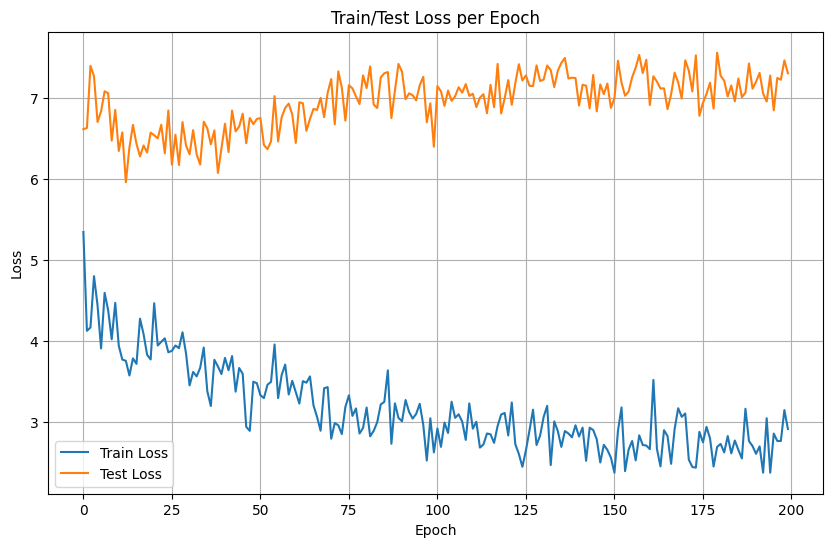

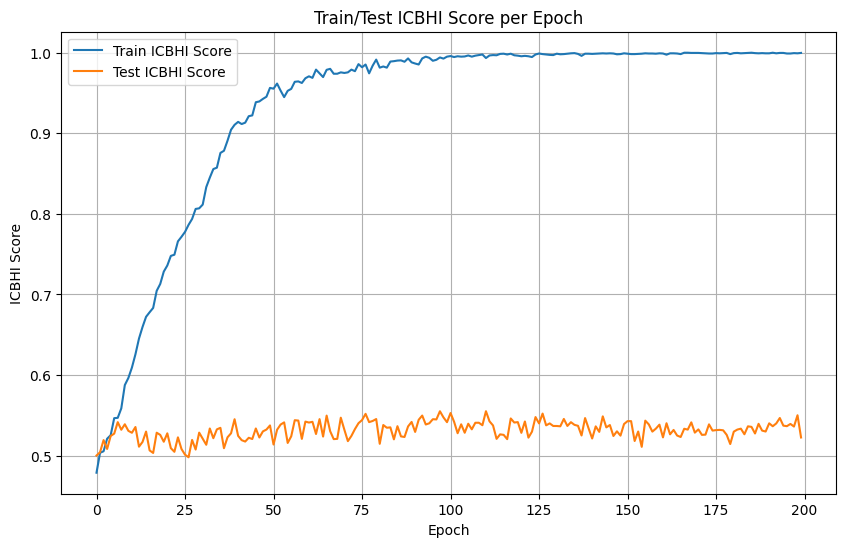


=== [최고 Test ICBHI Score 시점 정보] ===
Best Test ICBHI Score: 0.5550 (Epoch 110)
Test Loss at Best: 7.0533
Confusion Matrix at Best ICBHI Score:
[[1184  199  181   15]
 [ 330  292   20    7]
 [ 195   53  113   24]
 [  68   29   27   19]]
Sensitivity: 0.3602, Specificity: 0.7498, ICBHI Score: 0.5550
Best Epoch: 110


In [41]:
# --- 훈련 종료 후 그래프 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(epochs, train_icbhi_scores, label='Train ICBHI Score')
plt.plot(epochs, test_icbhi_scores, label='Test ICBHI Score')
plt.xlabel('Epoch')
plt.ylabel('ICBHI Score')
plt.title('Train/Test ICBHI Score per Epoch')
plt.legend()
plt.grid(True)
plt.show()

best_epoch_idx = np.argmax(test_icbhi_scores)
best_epoch = epochs[best_epoch_idx]
best_icbhi_score = test_icbhi_scores[best_epoch_idx]
best_test_loss = test_losses[best_epoch_idx]

# 최고점 epoch에서의 labels, preds
best_test_labels = test_labels_all[best_epoch_idx]
best_test_preds = test_preds_all[best_epoch_idx]

best_cm, best_sens, best_spec, best_y_true_cls, best_y_pred_cls = evaluate_multiclass_confusion(
    best_test_labels, best_test_preds)

print("\n=== [최고 Test ICBHI Score 시점 정보] ===")
print(f"Best Test ICBHI Score: {best_icbhi_score:.4f} (Epoch {best_epoch})")
print(f"Test Loss at Best: {best_test_loss:.4f}")
print("Confusion Matrix at Best ICBHI Score:")
print(best_cm)
print(f"Sensitivity: {best_sens:.4f}, Specificity: {best_spec:.4f}, ICBHI Score: {(best_sens+best_spec)/2:.4f}")
print(f"Best Epoch: {best_epoch}")


### Validate

In [42]:
# # 1. 모델 구조 정의
# model = MixMLATT(backbone=backbone_cnn6,
#                  num_classes=2,
#                  lambda_attn=0.5,
#                  attention_heads=[1, float('inf')]).cuda()


# ## 2. 훈련된 weight 로드 (best checkpoint or last epoch)
# checkpoint = torch.load("/home/ressera3/BOAZ-Chungzins/notebook/0721note_ckp/0723_sbw_basefalse_0.3alpha_MultilabelAtt_T_128bs_2507230158_best.pth.tar")  # 예: "checkpoints/pretrain_best.pth.tar"

# model.load_state_dict(checkpoint['model'])
# classifier.load_state_dict(checkpoint['classifier'])
# projector_0.load_state_dict(checkpoint['projector_0'])
# projector_1.load_state_dict(checkpoint['projector_1'])

# model.eval()

# ## 3. 손실 함수 및 device 설정
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# criterion = [
#     nn.BCEWithLogitsLoss().to(device),
#     GroupMixConLoss(temperature=0.07).to(device)
# ]

# ## 4. 평가 실행 (validate 함수 호출)
# test_loss, test_labels, test_preds = validate(
#     model=model,
#     classifier=classifier,
#     projector_0=projector_0,
#     projector_1=projector_1,
#     val_loader=test_loader,   # test_loader는 미리 정의되어 있어야 함
#     criterion=criterion,
#     device=device,
#     args=args            # args는 이전 학습 설정값들 포함
# )

# ## 5. 평가 결과 출력
# from sklearn.metrics import precision_score, recall_score, f1_score

# precision = precision_score(test_labels, test_preds, average='macro')
# recall = recall_score(test_labels, test_preds, average='macro')
# f1 = f1_score(test_labels, test_preds, average='macro')

# print(f"[Final Test] Loss: {test_loss:.4f}")
# print(f"[Final Test] Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# ## 6. Confusion Matrix 및 ICBHI Score 평가
# def evaluate_multiclass_confusion(y_true, y_pred, class_names=["Normal", "Wheeze", "Crackle", "Both"]):
#     y_true_cls = multilabel_to_multiclass(y_true)
#     y_pred_cls = multilabel_to_multiclass(y_pred)

#     cm = confusion_matrix(y_true_cls, y_pred_cls, labels=[0, 1, 2, 3])

#     # N_n: 정상 → 정상
#     N_n = cm[0, 0]
#     N_total = cm[0].sum()

#     # 이상 클래스 정답 수: W, C, B
#     W_total = cm[1].sum()
#     C_total = cm[2].sum()
#     B_total = cm[3].sum()

#     # 각각의 정답 → 정확한 예측만 고려
#     W_w = cm[1, 1]
#     C_c = cm[2, 2]
#     B_b = cm[3, 3]

#     SP = N_n / (N_total + 1e-6) #spec
#     SE = (W_w + C_c + B_b) / (W_total + C_total + B_total + 1e-6) #sense

#     AS = (SP + SE) / 2
#     HS = 2 * SP * SE / (SP + SE + 1e-6)

#     return cm, SE, SP, y_true_cls, y_pred_cls

# def multilabel_to_multiclass(y):
#     # Crackle → 1, Wheeze → 2, Both → 3, None → 0
#     y = np.array(y)
#     return y[:, 0] + y[:, 1]*2
# cm, sens, spec, y_true_cls, y_pred_cls = evaluate_multiclass_confusion(test_labels, test_preds)
# print(f"[Final Test] Confusion Matrix:\n{cm}")
# print(f"[Final Test] Sensitivity: {sens:.4f}, Specificity: {spec:.4f}, ICBHI Score: {(sens+spec)/2:.4f}")


